# Installs & Imports

In [1]:
!pip install -q yfinance ta torch torchvision optuna lion-pytorch pykalman

In [2]:
import yfinance as yf
import ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.trial import TrialState

from pykalman import KalmanFilter

import os
import random
import json

import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Load the Data

In [4]:
def fetch_data(ticker='^GSPC', start='2000-01-01', end='2024-10-22'):
    """
    Fetch historical data for the specified ticker.

    Args:
        ticker (str): Stock ticker symbol.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing the 'Close' prices with a clean index.
    """
    # Download data using yfinance
    data = yf.download(ticker, start=start, end=end)

    # Select only the 'Close' column
    data = data[['Close']].copy()

    # Check if columns have a MultiIndex and flatten them if necessary
    if isinstance(data.columns, pd.MultiIndex):
        # Combine multi-index levels into single level
        data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Remove the time component from the Date index by converting to datetime.date
    data.index = pd.to_datetime(data.index).date

    # Rename the index to 'Date' for clarity
    data.index.name = 'Date'

    # Rename the column to 'Close'
    data.columns = ['Close']

    return data

In [5]:
# Load the data
data = fetch_data()
print("\n\nFirst five rows of the data:")
display(data.head(10))
print("\nLast five rows of the data:")
display(data.tail(10))

[*********************100%***********************]  1 of 1 completed



First five rows of the data:


,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976
2000-01-11,1438.560059
2000-01-12,1432.250000
2000-01-13,1449.680054



Last five rows of the data:


,Close
Date,
2024-10-08,5751.129883
2024-10-09,5792.040039
2024-10-10,5780.049805
2024-10-11,5815.029785
2024-10-14,5859.850098
2024-10-15,5815.259766
2024-10-16,5842.470215
2024-10-17,5841.470215
2024-10-18,5864.669922


# Explore the Data

In [6]:
def descriptive_statistics(data):
    """
    Display descriptive statistics of the data.

    Args:
        data (pd.DataFrame): DataFrame containing the data.
    """
    desc_stats = data.describe()
    print("Descriptive Statistics:")
    display(desc_stats)

descriptive_statistics(data)

Descriptive Statistics:


,Close
count,6240.000000
mean,2081.921106
std,1200.680324
min,676.530029
25%,1198.780029
50%,1481.549988
75%,2727.030029
max,5864.669922


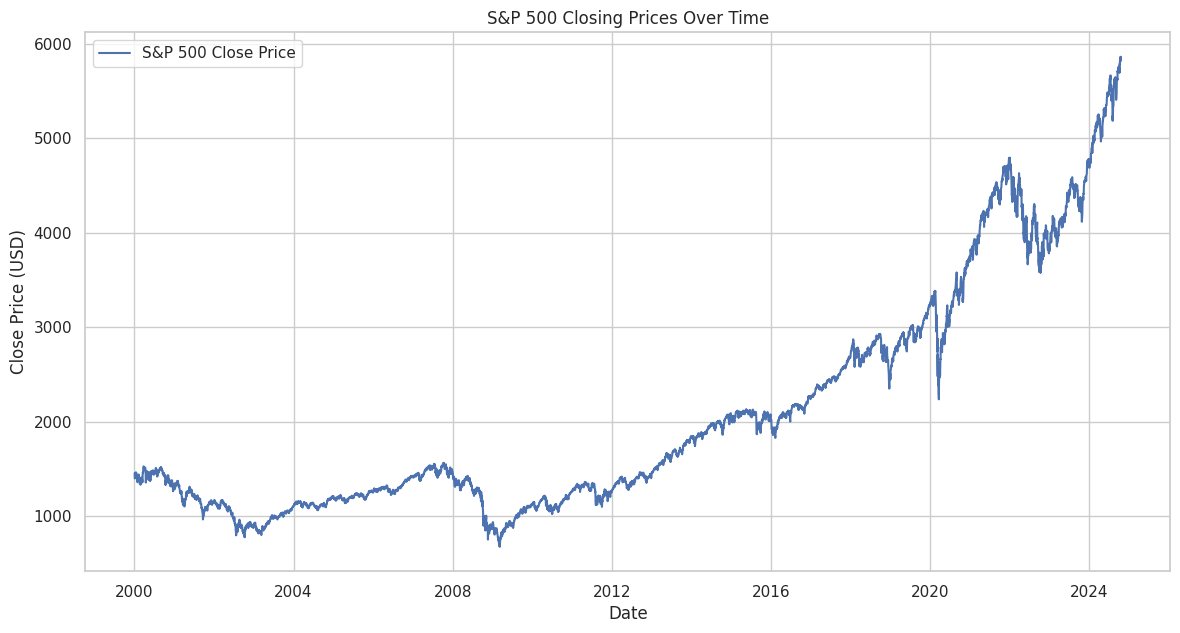

In [7]:
def plot_closing_prices(data):
    """
    Plot the closing prices over time.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
    """
    plt.figure(figsize=(14,7))
    plt.plot(data.index, data['Close'], label='S&P 500 Close Price')
    plt.title('S&P 500 Closing Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.show()

plot_closing_prices(data)

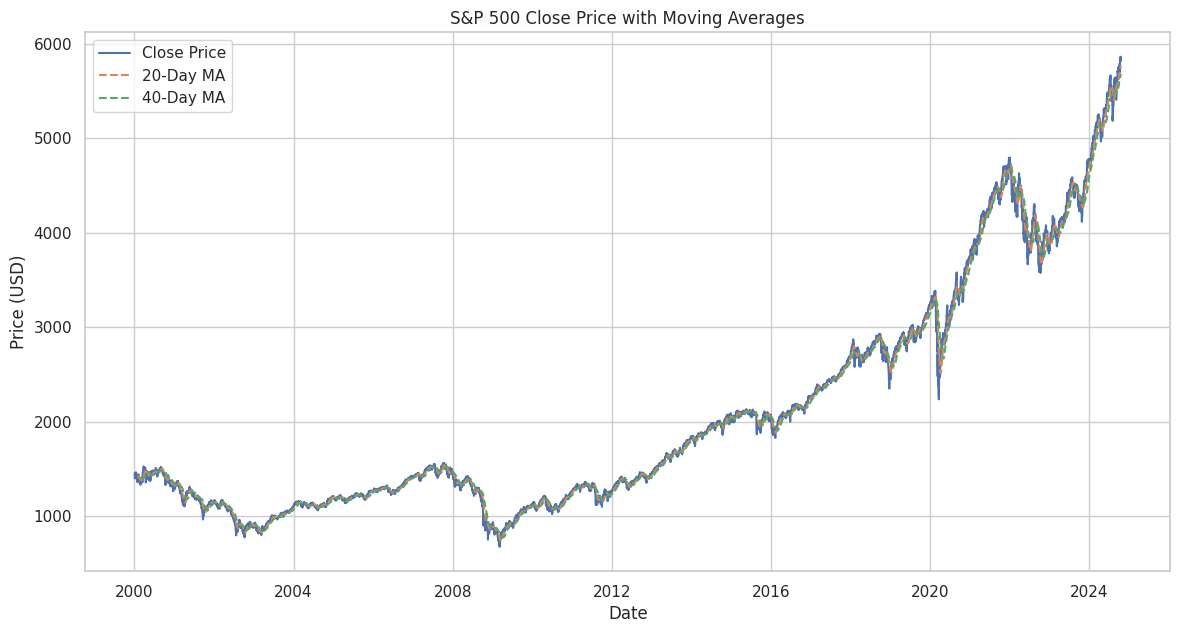

In [8]:
def plot_moving_averages(data, windows=[20, 40]):
    """
    Plot closing prices along with specified moving averages.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        windows (list): List of window sizes for moving averages.
    """
    data_copy = data.copy()
    for window in windows:
        data_copy[f'{window}_MA'] = data_copy['Close'].rolling(window=window).mean()

    plt.figure(figsize=(14,7))
    plt.plot(data_copy.index, data_copy['Close'], label='Close Price')
    for window in windows:
        plt.plot(data_copy.index, data_copy[f'{window}_MA'], label=f'{window}-Day MA', linestyle='--')
    plt.title('S&P 500 Close Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

plot_moving_averages(data)

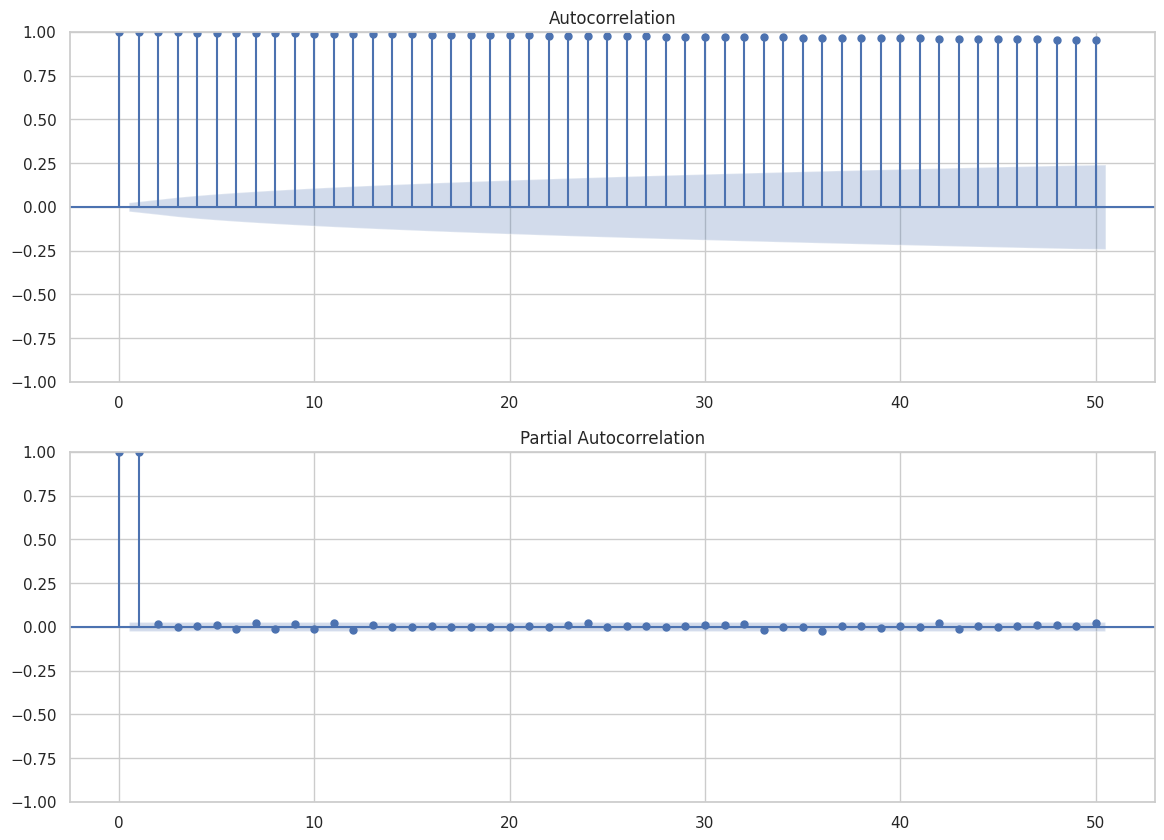


ADF Statistic: 2.629556
p-value: 0.999080
The time series is non-stationary.


In [9]:
def autocorrelation_stationarity(data):
    """
    Plot ACF and PACF and perform the Augmented Dickey-Fuller test.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
    """
    # Plot ACF and PACF
    fig, ax = plt.subplots(2,1, figsize=(14,10))
    plot_acf(data['Close'].dropna(), ax=ax[0], lags=50)
    plot_pacf(data['Close'].dropna(), ax=ax[1], lags=50)
    plt.show()

    # Augmented Dickey-Fuller test for stationarity
    adf_result = adfuller(data['Close'].dropna())
    print('\nADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])

    if adf_result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

autocorrelation_stationarity(data)

In [10]:
def add_moving_average(data, window=20):
    """
    Add a moving average feature to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        window (int): Window size for moving average.

    Returns:
        pd.DataFrame: DataFrame with the new moving average column.
    """
    data[f'{window}_MA'] = data['Close'].rolling(window=window).mean()
    data = data.dropna()
    return data

In [11]:
# Add moving averages
data = add_moving_average(data, window=20)
data = add_moving_average(data, window=40)
print("Data after adding 20-Day and 40-Day Moving Averages:")
display(data.head())

Data after adding 20-Day and 40-Day Moving Averages:


,Close,20_MA,40_MA
Date,,,
2000-03-27,1523.859985,1426.727991,1408.502243
2000-03-28,1507.729980,1433.793488,1411.333994
2000-03-29,1508.520020,1440.259991,1413.814993
2000-03-30,1487.920044,1445.567993,1415.784995
2000-03-31,1498.579956,1450.038489,1417.625244


In [12]:
def add_technical_indicators(data):
    """
    Add technical indicators to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.

    Returns:
        pd.DataFrame: DataFrame with the new technical indicators.
    """
    # Exponential Moving Average (EMA)
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

    # Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_diff'] = macd.macd_diff()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20)
    data['BB_high'] = bollinger.bollinger_hband()
    data['BB_low'] = bollinger.bollinger_lband()

    # Drop rows with NaN values
    data = data.dropna()

    return data

In [13]:
# Add other technical indicators
data = add_technical_indicators(data)
print("Data after adding technical indicators:")
display(data.head())

Data after adding technical indicators:


,Close,20_MA,40_MA,EMA_20,RSI,MACD,MACD_diff,BB_high,BB_low
Date,,,,,,,,,
2000-05-12,1420.959961,1428.361505,1462.068747,1434.555079,45.141792,-18.999853,-1.486231,1486.252439,1370.470571
2000-05-15,1452.359985,1433.151501,1461.765997,1436.250784,51.691062,-15.271166,1.793965,1481.563069,1384.739934
2000-05-16,1466.040039,1436.381506,1462.001248,1439.087856,54.253490,-11.084513,4.784494,1484.518339,1388.244674
2000-05-17,1447.800049,1436.691010,1460.849500,1439.917589,50.413808,-9.133095,5.388730,1485.037475,1388.344544
2000-05-18,1437.209961,1437.178009,1459.263748,1439.659719,48.277462,-8.344919,4.941525,1485.338993,1389.017025


In [14]:
def add_lagged_features(data, lags=[1, 2, 3, 4, 5, 10, 15, 20]):
    """
    Add lagged features to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        lags (list): List of lag periods to add.

    Returns:
        pd.DataFrame: DataFrame with new lagged feature columns.
    """
    for lag in lags:
        data[f'Close_lag_{lag}'] = data['Close'].shift(lag)
    data = data.dropna()
    return data

In [15]:
# Add lagged features
data = add_lagged_features(data, lags=[1, 2, 3, 4, 5, 10, 15, 20])
print("Data after adding lagged features:")
display(data.head())

Data after adding lagged features:


,Close,20_MA,40_MA,EMA_20,RSI,MACD,MACD_diff,BB_high,BB_low,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_10,Close_lag_15,Close_lag_20
Date,,,,,,,,,,,,,,,,,
2000-06-12,1446.000000,1433.704999,1431.033252,1440.919817,51.307063,5.915557,5.438869,1498.610010,1368.799988,1456.949951,1461.670044,1471.359985,1457.839966,1467.630005,1378.020020,1406.949951,1420.959961
2000-06-13,1469.439941,1434.558997,1433.855249,1443.636019,56.202480,7.321432,5.475795,1500.857856,1368.260138,1446.000000,1456.949951,1461.670044,1471.359985,1457.839966,1422.449951,1400.719971,1452.359985
2000-06-14,1470.540039,1434.783997,1435.582751,1446.198307,56.423907,8.427223,5.265269,1501.537664,1368.030329,1469.439941,1446.000000,1456.949951,1461.670044,1471.359985,1420.599976,1373.859985,1466.040039
2000-06-15,1478.729980,1436.330493,1436.510751,1449.296562,58.121401,9.850875,5.351137,1505.604239,1367.056747,1470.540039,1469.439941,1446.000000,1456.949951,1461.670044,1448.810059,1399.050049,1447.800049
2000-06-16,1464.459961,1437.692993,1437.435501,1450.740695,54.162394,9.715662,4.172740,1508.045853,1367.340133,1478.729980,1470.540039,1469.439941,1446.000000,1456.949951,1477.260010,1381.520020,1437.209961


In [16]:
# Initialize the Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=data['Close'].values[0],
                  observation_covariance=1,
                  transition_covariance=0.1)

# Apply the filter
state_means, _ = kf.filter(data['Close'].values)

# Add the filtered data to the dataframe
data['Kalman_Filtered_Close'] = state_means

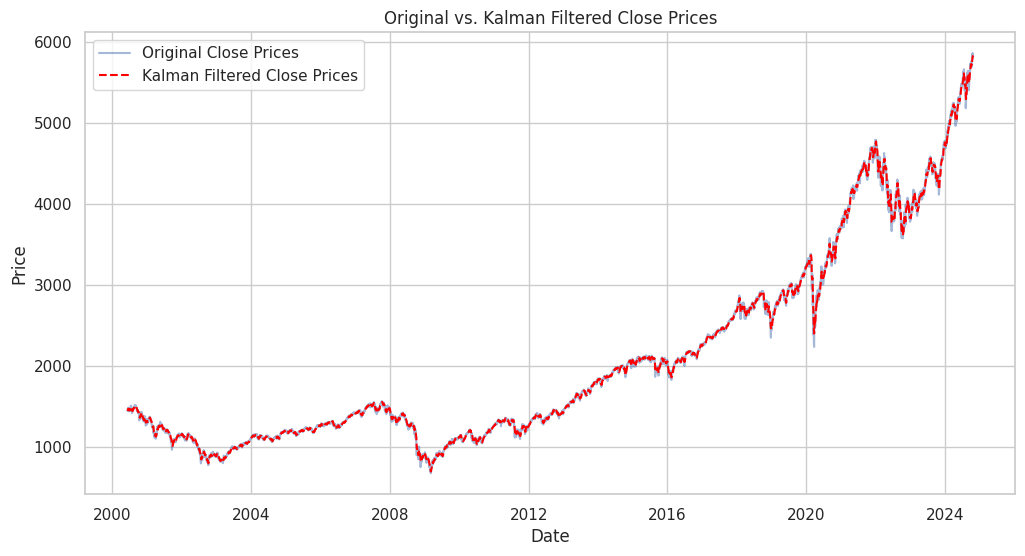

In [17]:
# Plot the original and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Close Prices', alpha=0.5)
plt.plot(data.index, data['Kalman_Filtered_Close'], label='Kalman Filtered Close Prices', color='red', linestyle='--')
plt.title('Original vs. Kalman Filtered Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Compute correlation matrix
corr_matrix = data.corr()
display(corr_matrix['Close'].sort_values(ascending=False))

,Close
Close,1.000000
Kalman_Filtered_Close,0.999768
Close_lag_1,0.999768
Close_lag_2,0.999577
Close_lag_3,0.999371
Close_lag_4,0.999171
EMA_20,0.999154
Close_lag_5,0.998981
20_MA,0.998808
BB_low,0.998560


# Prepare the Data

In [19]:
# Define feature and target columns
include_lags = False

if include_lags == True:
    feature_cols = ['Close'] + [f'Close_lag_{lag}' for lag in [1, 2, 3, 4, 5, 10, 15, 20]]
else:
    feature_cols = ['Close']

target_col = 'Close'

In [20]:
def create_sequences_and_split(data, feature_cols, target_col, seq_length=60, train_size=0.7, val_size=0.15):
    """
    Create sequences from the data and split into training, validation, and test sets.

    Args:
        data (pd.DataFrame): The complete dataset.
        feature_cols (list): List of feature column names.
        target_col (str): Target column name.
        seq_length (int): Length of each input sequence.
        train_size (float): Proportion of data to use for training.
        val_size (float): Proportion of data to use for validation.

    Returns:
        Tuple: Sequences and targets for training, validation, and test sets.
    """
    # Extract features and target
    features = data[feature_cols].values
    target = data[target_col].values.reshape(-1, 1)

    # Create sequences
    sequences = []
    targets = []
    for i in range(len(features) - seq_length):
        seq = features[i:i + seq_length]
        target_val = target[i + seq_length]
        sequences.append(seq)
        targets.append(target_val)

    sequences = np.array(sequences)
    targets = np.array(targets)

    # Calculate split indices
    total_sequences = len(sequences)
    train_end = int(total_sequences * train_size)
    val_end = train_end + int(total_sequences * val_size)

    # Split sequences and targets
    X_train = sequences[:train_end]
    y_train = targets[:train_end]

    X_val = sequences[train_end:val_end]
    y_val = targets[train_end:val_end]

    X_test = sequences[val_end:]
    y_test = targets[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
# Create sequences and split the data
seq_length = 60  # Using 60 days to predict the next day
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq = create_sequences_and_split(
    data, feature_cols, target_col, seq_length=seq_length, train_size=0.7, val_size=0.15
)

print("Training sequences shape:", X_train_seq.shape)
print("Training targets shape:", y_train_seq.shape)

print("\nValidation sequences shape:", X_val_seq.shape)
print("Validation targets shape:", y_val_seq.shape)

print("\nTest sequences shape:", X_test_seq.shape)
print("Test targets shape:", y_test_seq.shape)

Training sequences shape: (4248, 60, 1)
Training targets shape: (4248, 1)

Validation sequences shape: (910, 60, 1)
Validation targets shape: (910, 1)

Test sequences shape: (911, 60, 1)
Test targets shape: (911, 1)


In [22]:
def scale_sequences(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Scale sequences and targets using scalers fitted on training data.

    Args:
        X_train (np.ndarray): Training sequences.
        y_train (np.ndarray): Training targets.
        X_val (np.ndarray): Validation sequences.
        y_val (np.ndarray): Validation targets.
        X_test (np.ndarray): Test sequences.
        y_test (np.ndarray): Test targets.

    Returns:
        Tuple: Scaled sequences and targets, scalers for features and target.
    """
    # Reshape X_train for scaling
    num_samples_train, seq_length, num_features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, num_features)

    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    # Fit scalers on training data
    scaled_X_train_reshaped = scaler_features.fit_transform(X_train_reshaped)
    scaled_y_train = scaler_target.fit_transform(y_train)

    # Reshape back to original shape
    scaled_X_train = scaled_X_train_reshaped.reshape(num_samples_train, seq_length, num_features)

    # Scale validation data
    num_samples_val = X_val.shape[0]
    X_val_reshaped = X_val.reshape(-1, num_features)
    scaled_X_val_reshaped = scaler_features.transform(X_val_reshaped)
    scaled_X_val = scaled_X_val_reshaped.reshape(num_samples_val, seq_length, num_features)
    scaled_y_val = scaler_target.transform(y_val)

    # Scale test data
    num_samples_test = X_test.shape[0]
    X_test_reshaped = X_test.reshape(-1, num_features)
    scaled_X_test_reshaped = scaler_features.transform(X_test_reshaped)
    scaled_X_test = scaled_X_test_reshaped.reshape(num_samples_test, seq_length, num_features)
    scaled_y_test = scaler_target.transform(y_test)

    return (scaled_X_train, scaled_y_train,
            scaled_X_val, scaled_y_val,
            scaled_X_test, scaled_y_test,
            scaler_features, scaler_target)

In [23]:
# Scale the sequences and targets
scaled_X_train, scaled_y_train, scaled_X_val, scaled_y_val, scaled_X_test, scaled_y_test, scaler_features, scaler_target = scale_sequences(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq
)

print("Scaled training sequences shape:", scaled_X_train.shape)
print("Scaled training targets shape:", scaled_y_train.shape)

print("\nScaled validation sequences shape:", scaled_X_val.shape)
print("Scaled validation targets shape:", scaled_y_val.shape)

print("\nScaled test sequences shape:", scaled_X_test.shape)
print("Scaled test targets shape:", scaled_y_test.shape)

Scaled training sequences shape: (4248, 60, 1)
Scaled training targets shape: (4248, 1)

Scaled validation sequences shape: (910, 60, 1)
Scaled validation targets shape: (910, 1)

Scaled test sequences shape: (911, 60, 1)
Scaled test targets shape: (911, 1)


In [24]:
# Convert scaled data to tensors
X_train = torch.tensor(scaled_X_train, dtype=torch.float32)
y_train = torch.tensor(scaled_y_train, dtype=torch.float32)

X_val = torch.tensor(scaled_X_val, dtype=torch.float32)
y_val = torch.tensor(scaled_y_val, dtype=torch.float32)

X_test = torch.tensor(scaled_X_test, dtype=torch.float32)
y_test = torch.tensor(scaled_y_test, dtype=torch.float32)

In [25]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """
    Create DataLoader objects for training, validation, and test sets.

    Args:
        X_train (torch.Tensor): Training input sequences.
        y_train (torch.Tensor): Training targets.
        X_val (torch.Tensor): Validation input sequences.
        y_val (torch.Tensor): Validation targets.
        X_test (torch.Tensor): Test input sequences.
        y_test (torch.Tensor): Test targets.
        batch_size (int): Batch size.

    Returns:
        Tuple: Training, validation, and test DataLoaders.
    """
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [26]:
# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32
)

print("Number of batches in training loader:", len(train_loader))
print("Number of batches in validation loader:", len(val_loader))
print("Number of batches in test loader:", len(test_loader))

# Display the shape of the first batch in each loader
first_train_batch = next(iter(train_loader))
print("\nShape of first batch in training loader:", first_train_batch[0].shape)

first_val_batch = next(iter(val_loader))
print("Shape of first batch in validation loader:", first_val_batch[0].shape)

first_test_batch = next(iter(test_loader))
print("Shape of first batch in test loader:", first_test_batch[0].shape)

Number of batches in training loader: 133
Number of batches in validation loader: 29
Number of batches in test loader: 29

Shape of first batch in training loader: torch.Size([32, 60, 1])
Shape of first batch in validation loader: torch.Size([32, 60, 1])
Shape of first batch in test loader: torch.Size([32, 60, 1])


# Define the Models

## With Sinusoidal Embeddings

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Initialize the standard sinusoidal positional encoding.

        Args:
            d_model (int): Embedding dimension.
            max_len (int): Maximum sequence length.
        """
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # Shape: (d_model // 2,)

        # Compute the positional encodings
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, seq_len, d_model)

        Returns:
            torch.Tensor: Output tensor with positional encoding added.
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

In [28]:
class StandardTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward=1024, dropout=0.1):
        """
        Initialize the standard Transformer Encoder Layer.

        Args:
            embed_dim (int): Embedding dimension.
            num_heads (int): Number of attention heads.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
        """
        super(StandardTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        """
        Forward pass for the standard Transformer Encoder Layer.

        Args:
            src (torch.Tensor): Input tensor of shape (batch, seq_len, embed_dim)
            src_mask (torch.Tensor): Source mask of shape (seq_len, seq_len)

        Returns:
            torch.Tensor: Output tensor of shape (batch, seq_len, embed_dim)
        """
        # MultiheadAttention expects (seq_len, batch, embed_dim)
        src_transposed = src.transpose(0, 1)  # Shape: (seq_len, batch, embed_dim)

        # Mask application
        if src_mask is not None:
            # src_mask should be of shape (seq_len, seq_len)
            # Convert boolean mask to float mask with -1e9 for masked positions
            src_mask = src_mask.float().masked_fill(src_mask == 0, -1e9)
            src_mask = src_mask.masked_fill(src_mask == 1, 0.0)

        attn_output, _ = self.self_attn(src_transposed, src_transposed, src_transposed, attn_mask=src_mask)
        attn_output = attn_output.transpose(0, 1)  # Shape: (batch, seq_len, embed_dim)

        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

In [29]:
class StandardTimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, num_layers=4, num_heads=8, hidden_dim=256, dropout=0.1, seq_length=60):
        """
        Initialize the Standard Time Series Transformer model.

        Args:
            feature_size (int): Number of input features.
            num_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads.
            hidden_dim (int): Hidden dimension size.
            dropout (float): Dropout rate.
            seq_length (int): Sequence length.
        """
        super(StandardTimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim

        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, max_len=seq_length)

        # Stack of Standard Transformer Encoder Layers
        self.encoder_layers = nn.ModuleList([
            StandardTransformerEncoderLayer(
                embed_dim=hidden_dim,
                num_heads=num_heads,
                dim_feedforward=hidden_dim * 4,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """
        Initialize the weights of the model.
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def generate_square_subsequent_mask(self, sz):
        """
        Generate a causal mask for the transformer encoder.

        Args:
            sz (int): Size of the mask (sequence length).

        Returns:
            torch.Tensor: Causal mask of shape (sz, sz)
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        mask = mask.to(next(self.parameters()).device)
        return mask  # Shape: (sz, sz)

    def forward(self, src):
        """
        Forward pass for the Standard Time Series Transformer.

        Args:
            src (torch.Tensor): Input tensor of shape (batch, seq_len, feature_size)

        Returns:
            torch.Tensor: Output tensor of shape (batch, 1)
        """
        batch_size, seq_len, _ = src.size()
        device = src.device

        src_mask = self.generate_square_subsequent_mask(seq_len)  # Shape: (seq_len, seq_len)

        x = self.input_linear(src)  # (batch, seq_len, hidden_dim)
        x = self.pos_encoder(x)      # Add positional encoding

        # Pass through transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x, src_mask=src_mask)

        # Use the last time step's output for prediction
        x = x[:, -1, :]  # (batch, hidden_dim)
        output = self.decoder(x)  # (batch, 1)
        return output

## With Rotary Embeddings

In [30]:
def apply_rotary_pos_emb(q, k, cos, sin):
    """
    Apply rotary positional embeddings to the query and key tensors.

    Args:
        q (torch.Tensor): Query tensor of shape (batch, num_heads, seq_len, head_dim)
        k (torch.Tensor): Key tensor of shape (batch, num_heads, seq_len, head_dim)
        cos (torch.Tensor): Cosine tensor of shape (seq_len, head_dim // 2)
        sin (torch.Tensor): Sine tensor of shape (seq_len, head_dim // 2)

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Rotated query and key tensors.
    """
    # Ensure head_dim is even
    assert q.size(-1) % 2 == 0, "head_dim must be even for rotary embeddings"

    # Split head_dim into two halves
    q1, q2 = torch.chunk(q, 2, dim=-1)
    k1, k2 = torch.chunk(k, 2, dim=-1)

    # Apply RoPE
    q_rot = torch.cat([q1 * cos - q2 * sin, q1 * sin + q2 * cos], dim=-1)
    k_rot = torch.cat([k1 * cos - k2 * sin, k1 * sin + k2 * cos], dim=-1)

    return q_rot, k_rot

In [31]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        """
        Initialize the Rotary Embedding.

        Args:
            dim (int): Dimension of the embeddings (should be even).
            base (int): Base for the frequency calculation.
        """
        super(RotaryEmbedding, self).__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, seq_len, device):
        """
        Generate the rotary positional embeddings.

        Args:
            seq_len (int): Sequence length.
            device (torch.device): Device to place the embeddings.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Cosine and sine embeddings.
        """
        positions = torch.arange(seq_len, device=device).type_as(self.inv_freq)
        sinusoid_inp = torch.einsum("i,j->ij", positions, self.inv_freq)  # (seq_len, dim // 2)
        sin = torch.sin(sinusoid_inp)  # (seq_len, dim // 2)
        cos = torch.cos(sinusoid_inp)  # (seq_len, dim // 2)
        return cos, sin  # Both are of shape (seq_len, dim // 2)

In [32]:
class RotaryMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        Initialize the Rotary Multi-Head Attention module.

        Args:
            embed_dim (int): Total dimension of the model.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout rate.
        """
        super(RotaryMultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert (
            embed_dim % num_heads == 0
        ), "embed_dim must be divisible by num_heads"

        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize Rotary Embedding
        self.rotary_emb = RotaryEmbedding(self.head_dim)

    def forward(self, x, attn_mask=None):
        """
        Forward pass for the Rotary Multi-Head Attention.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, seq_len, embed_dim)
            attn_mask (torch.Tensor): Attention mask of shape (seq_len, seq_len)

        Returns:
            torch.Tensor: Output tensor of shape (batch, seq_len, embed_dim)
        """
        batch_size, seq_len, embed_dim = x.size()
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (batch_size, num_heads, seq_len, head_dim)

        # Generate rotary embeddings
        cos, sin = self.rotary_emb(seq_len, x.device)  # Both are (seq_len, head_dim//2)
        cos = cos.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim//2)
        sin = sin.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim//2)

        # Apply RoPE to queries and keys
        q_rot, k_rot = apply_rotary_pos_emb(q, k, cos, sin)

        # Scaled dot-product attention
        attn_scores = torch.matmul(q_rot, k_rot.transpose(-2, -1)) * self.scale  # (batch_size, num_heads, seq_len, seq_len)

        # Apply causal mask if provided
        if attn_mask is not None:
            # Adjust attn_mask dimensions: (batch_size, num_heads, seq_len, seq_len)
            attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            attn_scores = attn_scores.masked_fill(attn_mask == 0, -1e9)

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Attention output
        attn_output = torch.matmul(attn_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)
        output = self.out(attn_output)  # (batch_size, seq_len, embed_dim)
        return output

In [33]:
class RotaryTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward=1024, dropout=0.1):
        """
        Initialize the Rotary Transformer Encoder Layer.

        Args:
            embed_dim (int): Total dimension of the model.
            num_heads (int): Number of attention heads.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
        """
        super(RotaryTransformerEncoderLayer, self).__init__()
        self.self_attn = RotaryMultiHeadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        """
        Forward pass for the Rotary Transformer Encoder Layer.

        Args:
            src (torch.Tensor): Input tensor of shape (batch, seq_len, embed_dim)
            src_mask (torch.Tensor): Source mask of shape (seq_len, seq_len)

        Returns:
            torch.Tensor: Output tensor of shape (batch, seq_len, embed_dim)
        """
        # Self-attention with RoPE and causal mask
        attn_output = self.self_attn(src, attn_mask=src_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feedforward network
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src

In [34]:
class RotaryTimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, num_layers=4, num_heads=8, hidden_dim=256, dropout=0.1, seq_length=60):
        """
        Initialize the Rotary Time Series Transformer model.

        Args:
            feature_size (int): Number of input features.
            num_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads.
            hidden_dim (int): Hidden dimension size.
            dropout (float): Dropout rate.
            seq_length (int): Sequence length.
        """
        super(RotaryTimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim

        self.input_linear = nn.Linear(feature_size, hidden_dim)

        # Stack of Rotary Transformer Encoder Layers
        self.encoder_layers = nn.ModuleList([
            RotaryTransformerEncoderLayer(
                embed_dim=hidden_dim,
                num_heads=num_heads,
                dim_feedforward=hidden_dim * 4,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """
        Initialize the weights of the model.
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def generate_square_subsequent_mask(self, sz):
        """
        Generate a causal mask for the transformer encoder.

        Args:
            sz (int): Size of the mask (sequence length).

        Returns:
            torch.Tensor: Causal mask of shape (sz, sz)
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        mask = mask.to(next(self.parameters()).device)
        return mask  # Shape: (sz, sz)

    def forward(self, src):
        """
        Forward pass for the Rotary Time Series Transformer.

        Args:
            src (torch.Tensor): Input tensor of shape (batch, seq_len, feature_size)

        Returns:
            torch.Tensor: Output tensor of shape (batch, 1)
        """
        batch_size, seq_len, _ = src.size()
        device = src.device

        src_mask = self.generate_square_subsequent_mask(seq_len)  # Shape: (seq_len, seq_len)

        x = self.input_linear(src)  # (batch, seq_len, hidden_dim)

        # Pass through transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x, src_mask=src_mask)

        # Use the last time step's output for prediction
        x = x[:, -1, :]  # (batch, hidden_dim)
        output = self.decoder(x)  # (batch, 1)
        return output

# Build the Models

In [35]:
def initialize_model(model_type, device, feature_size, num_layers=4, num_heads=8, hidden_dim=256, dropout=0.1, seq_length=60):
    """
    Initialize the transformer model based on the specified type.

    Args:
        model_type (str): Type of the model ('standard' or 'rotary').
        device (torch.device): Device to place the model.
        feature_size (int): Number of input features.
        num_layers (int): Number of transformer encoder layers.
        num_heads (int): Number of attention heads.
        hidden_dim (int): Hidden dimension size.
        dropout (float): Dropout rate.
        seq_length (int): Sequence length.

    Returns:
        Tuple: Initialized model, loss function, optimizer.
    """
    if model_type == 'standard':
        model = StandardTimeSeriesTransformer(
            feature_size=feature_size,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_length=seq_length
        ).to(device)
    elif model_type == 'rotary':
        model = RotaryTimeSeriesTransformer(
            feature_size=feature_size,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_length=seq_length
        ).to(device)
    else:
        raise ValueError("model_type must be either 'standard' or 'rotary'")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, criterion, optimizer

In [36]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set feature_size
feature_size = len(feature_cols)
print(f'\nFeature size: {feature_size}')

Using device: cuda

Feature size: 1


In [37]:
# Initialize Standard Positional Encoding Transformer
standard_model, standard_criterion, standard_optimizer = initialize_model(
    model_type='standard',
    device=device,
    feature_size=feature_size
)

# Initialize Rotary Positional Embedding Transformer
rotary_model, rotary_criterion, rotary_optimizer = initialize_model(
    model_type='rotary',
    device=device,
    feature_size=feature_size
)

# Train the Models

In [38]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=100,
    model_name='Model',
    early_stopping_patience=10,
    scheduler_patience=5,
    checkpoint_dir='checkpoints',
    trial=None
):
    """
    Train the transformer model with Early Stopping, Model Checkpointing, and Learning Rate Scheduling.
    Reports validation loss to Optuna for pruning.

    Args:
        model (nn.Module): The transformer model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device to train on.
        num_epochs (int): Maximum number of training epochs.
        model_name (str): Name of the model (for logging purposes).
        early_stopping_patience (int): Number of epochs to wait for improvement before stopping.
        scheduler_patience (int): Number of epochs with no improvement after which learning rate will be reduced.
        checkpoint_dir (str): Directory to save model checkpoints.
        trial (optuna.trial.Trial): Optuna trial object for pruning.

    Returns:
        Tuple: Lists of training and validation losses.
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Initialize the Learning Rate Scheduler with separate patience
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=scheduler_patience,
        verbose=True
    )

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_path = os.path.join(checkpoint_dir, f'{model_name}_best.pth')

    # Initialize previous learning rates for comparison
    prev_lrs = [group['lr'] for group in optimizer.param_groups]

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_X)
                loss = criterion(output, batch_y)
                running_val_loss += loss.item() * batch_X.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Scheduler Step: Adjust learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        # Retrieve current learning rates for logging
        current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]

        # Compare previous and current learning rates to detect reduction
        lr_reduced = False
        lr_changes = []
        for i, (prev_lr, current_lr) in enumerate(zip(prev_lrs, current_lrs)):
            if current_lr < prev_lr:
                lr_reduced = True
                lr_changes.append((i, prev_lr, current_lr))

        if lr_reduced:
            for grp_idx, old_lr, new_lr in lr_changes:
                print(f'--> {model_name}: Learning rate for parameter group {grp_idx} reduced from {old_lr:.6e} to {new_lr:.6e}')

        # Update previous learning rates for next comparison
        prev_lrs = current_lrs.copy()

        # Training log for learning rates
        formatted_lrs = [f"{lr:.6e}" for lr in current_lrs]
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.6f}, '
              f'Val Loss: {epoch_val_loss:.6f}, '
              f'LR: {formatted_lrs}')

        # Check for improvement in validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f'--> {model_name}: Validation loss decreased, saving model.')
        else:
            epochs_no_improve += 1
            print(f'--> {model_name}: No improvement in validation loss for {epochs_no_improve} epochs.')
            if epochs_no_improve >= early_stopping_patience:
                print(f'--> {model_name}: Early stopping triggered.')
                break

        # Report intermediate objective value for pruning
        if trial is not None:
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune():
                print(f'--> {model_name}: Trial pruned at epoch {epoch+1}.')
                raise optuna.exceptions.TrialPruned()

    # Load the best model before returning
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        print(f'--> {model_name}: Loaded the best model with validation loss {best_val_loss:.6f}')
    else:
        print(f'--> {model_name}: No model saved, training did not improve validation loss.')

    return train_losses, val_losses

In [39]:
print("Training Untuned Standard Positional Encoding Transformer...")
standard_train_losses, standard_val_losses = train_model(
    model=standard_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=standard_criterion,
    optimizer=standard_optimizer,
    device=device,
    num_epochs=100,
    model_name='Standard_PE_Transformer',
    early_stopping_patience=10,
    scheduler_patience=5,
    checkpoint_dir='checkpoints/standard_untuned'
)

Training Untuned Standard Positional Encoding Transformer...
Standard_PE_Transformer - Epoch [1/100], Train Loss: 0.136474, Val Loss: 0.011038, LR: ['1.000000e-04']
--> Standard_PE_Transformer: Validation loss decreased, saving model.
Standard_PE_Transformer - Epoch [2/100], Train Loss: 0.007253, Val Loss: 0.009407, LR: ['1.000000e-04']
--> Standard_PE_Transformer: Validation loss decreased, saving model.
Standard_PE_Transformer - Epoch [3/100], Train Loss: 0.005979, Val Loss: 0.038447, LR: ['1.000000e-04']
--> Standard_PE_Transformer: No improvement in validation loss for 1 epochs.
Standard_PE_Transformer - Epoch [4/100], Train Loss: 0.004233, Val Loss: 0.035170, LR: ['1.000000e-04']
--> Standard_PE_Transformer: No improvement in validation loss for 2 epochs.
Standard_PE_Transformer - Epoch [5/100], Train Loss: 0.004042, Val Loss: 0.053751, LR: ['1.000000e-04']
--> Standard_PE_Transformer: No improvement in validation loss for 3 epochs.
Standard_PE_Transformer - Epoch [6/100], Train L

In [40]:
print("Training Untuned Rotary Positional Embedding Transformer...")
rotary_train_losses, rotary_val_losses = train_model(
    model=rotary_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=rotary_criterion,
    optimizer=rotary_optimizer,
    device=device,
    num_epochs=100,
    model_name='Rotary_PE_Transformer',
    early_stopping_patience=10,
    scheduler_patience=5,
    checkpoint_dir='checkpoints/rotary_untuned'
)

Training Untuned Rotary Positional Embedding Transformer...
Rotary_PE_Transformer - Epoch [1/100], Train Loss: 0.131270, Val Loss: 0.066918, LR: ['1.000000e-04']
--> Rotary_PE_Transformer: Validation loss decreased, saving model.
Rotary_PE_Transformer - Epoch [2/100], Train Loss: 0.006550, Val Loss: 0.087268, LR: ['1.000000e-04']
--> Rotary_PE_Transformer: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer - Epoch [3/100], Train Loss: 0.004676, Val Loss: 0.054305, LR: ['1.000000e-04']
--> Rotary_PE_Transformer: Validation loss decreased, saving model.
Rotary_PE_Transformer - Epoch [4/100], Train Loss: 0.003968, Val Loss: 0.048097, LR: ['1.000000e-04']
--> Rotary_PE_Transformer: Validation loss decreased, saving model.
Rotary_PE_Transformer - Epoch [5/100], Train Loss: 0.003461, Val Loss: 0.100272, LR: ['1.000000e-04']
--> Rotary_PE_Transformer: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer - Epoch [6/100], Train Loss: 0.003203, Val Loss: 0.077

# Hyperparameter Tuning

In [41]:
def initialize_tuned_model(model_type, params, device, feature_size, seq_length=60):
    """
    Initialize the transformer model with tuned hyperparameters.

    Args:
        model_type (str): Type of the model ('standard' or 'rotary').
        params (dict): Dictionary of hyperparameters.
        device (torch.device): Device to place the model.
        feature_size (int): Number of input features.
        seq_length (int): Sequence length.

    Returns:
        Tuple: Initialized model, loss function, optimizer.
    """
    if model_type == 'standard':
        num_heads = params['num_heads_standard']
        hidden_dim = params['hidden_dim_standard']
        dropout = params['dropout_standard']

        if hidden_dim % num_heads != 0:
            raise ValueError("hidden_dim must be divisible by num_heads")
        head_dim = hidden_dim // num_heads

        model = StandardTimeSeriesTransformer(
            feature_size=feature_size,
            num_layers=params['num_layers_standard'],
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_length=seq_length
        ).to(device)
    elif model_type == 'rotary':
        num_heads = params['num_heads_rotary']
        hidden_dim = params['hidden_dim_rotary']
        dropout = params['dropout_rotary']

        if hidden_dim % num_heads != 0:
            raise ValueError("hidden_dim must be divisible by num_heads")
        head_dim = hidden_dim // num_heads

        if head_dim % 2 != 0:
            raise ValueError("head_dim must be even for rotary embeddings")

        model = RotaryTimeSeriesTransformer(
            feature_size=feature_size,
            num_layers=params['num_layers_rotary'],
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout=dropout,
            seq_length=seq_length
        ).to(device)
    else:
        raise ValueError("model_type must be either 'standard' or 'rotary'")

    # Select optimizer
    optimizer_name = params.get('optimizer_standard') if model_type == 'standard' else params.get('optimizer_rotary')
    learning_rate = params.get('learning_rate_standard') if model_type == 'standard' else params.get('learning_rate_rotary')

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Nadam':
        optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Lion':
        try:
            from lion_pytorch import Lion
            optimizer = Lion(model.parameters(), lr=learning_rate)
        except ImportError:
            raise ImportError("lion-pytorch is required for the Lion optimizer.")
    else:
        raise ValueError("Unsupported optimizer")

    criterion = nn.MSELoss()

    return model, criterion, optimizer

In [42]:
def objective_standard(trial):
    """
    Objective function for Optuna hyperparameter tuning for the Standard Transformer.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Average validation loss across all folds.
    """
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers_standard', 2, 6)
    num_heads = trial.suggest_int('num_heads_standard', 4, 12)
    hidden_dim = trial.suggest_int('hidden_dim_standard', 128, 512, step=64)
    dropout = trial.suggest_float('dropout_standard', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate_standard', 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_standard', ['Adam', 'AdamW', 'Nadam', 'Lion'])

    # Ensure hidden_dim is divisible by num_heads
    if hidden_dim % num_heads != 0:
        raise optuna.exceptions.TrialPruned()

    # Use only the training data
    X = X_train
    y = y_train

    # Initialize TimeSeriesSplit
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    fold_val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # Create DataLoaders for this fold
        train_dataset_cv = TensorDataset(X_train_cv, y_train_cv)
        val_dataset_cv = TensorDataset(X_val_cv, y_val_cv)
        train_loader_cv = DataLoader(train_dataset_cv, batch_size=32, shuffle=True)
        val_loader_cv = DataLoader(val_dataset_cv, batch_size=32, shuffle=False)

        # Initialize model and optimizer
        try:
            model_cv, criterion_cv, optimizer_cv = initialize_tuned_model(
                model_type='standard',
                params={
                    'num_layers_standard': num_layers,
                    'num_heads_standard': num_heads,
                    'hidden_dim_standard': hidden_dim,
                    'dropout_standard': dropout,
                    'optimizer_standard': optimizer_name,
                    'learning_rate_standard': learning_rate
                },
                device=device,
                feature_size=feature_size,
                seq_length=seq_length
            )
        except Exception as e:
            # If model initialization fails, prune the trial
            print(f"Model initialization failed on fold {fold+1}: {e}")
            raise optuna.exceptions.TrialPruned()

        # Call train_model
        try:
            train_losses_cv, val_losses_cv = train_model(
                model=model_cv,
                train_loader=train_loader_cv,
                val_loader=val_loader_cv,
                criterion=criterion_cv,
                optimizer=optimizer_cv,
                device=device,
                num_epochs=50,
                model_name=f'Standard_PE_Transformer_fold{fold+1}',
                early_stopping_patience=5,
                scheduler_patience=3,
                checkpoint_dir=f'checkpoints/standard_fold{fold+1}',
                trial=trial
            )
        except optuna.exceptions.TrialPruned:
            print(f"Trial pruned on fold {fold+1}.")
            raise
        except Exception as e:
            # If training fails, prune the trial
            print(f"Training failed on fold {fold+1}: {e}")
            raise optuna.exceptions.TrialPruned()

        # Get the final validation loss
        final_val_loss = val_losses_cv[-1]
        fold_val_losses.append(final_val_loss)

    # Compute average validation loss
    avg_val_loss = np.mean(fold_val_losses)
    return avg_val_loss

In [43]:
# Create and optimize the study for the Standard Transformer
study_standard = optuna.create_study(direction='minimize', study_name='Standard_PE_Transformer')
study_standard.optimize(objective_standard, n_trials=50, timeout=3600)

print('\nStandard Transformer - Best Trial:')
print(f'  Value: {study_standard.best_trial.value}')
print('  Params: ')
for key, value in study_standard.best_trial.params.items():
    print(f'    {key}: {value}')

best_params_standard = study_standard.best_trial.params

[I 2024-10-24 13:59:07,359] A new study created in memory with name: Standard_PE_Transformer


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.973638, Val Loss: 0.003961, LR: ['9.696945e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.131540, Val Loss: 0.015992, LR: ['9.696945e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.041846, Val Loss: 0.026667, LR: ['9.696945e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 2 epochs.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.023054, Val Loss: 0.014105, LR: ['9.696945e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 3 epochs.
--> Standard_PE_Transformer_fold1: Learning rate for parameter group 0 reduced from 9.696945e-05 to 9.696945e-06
Standard_PE_Transformer_fold1 - Epoch [5/50], Train Loss: 0.022249, Val Loss: 0.010739, LR: ['9.696945e-06']
--> Standard_PE_T

[I 2024-10-24 14:07:40,453] Trial 0 finished with value: 0.008768409483909534 and parameters: {'num_layers_standard': 3, 'num_heads_standard': 12, 'hidden_dim_standard': 384, 'dropout_standard': 0.3454902616293104, 'learning_rate_standard': 9.696944970889999e-05, 'optimizer_standard': 'Nadam'}. Best is trial 0 with value: 0.008768409483909534.


Standard_PE_Transformer_fold5 - Epoch [10/50], Train Loss: 0.004411, Val Loss: 0.005517, LR: ['9.696945e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.001524
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.731243, Val Loss: 0.006941, LR: ['2.924725e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.031154, Val Loss: 0.004681, LR: ['2.924725e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.015973, Val Loss: 0.002128, LR: ['2.924725e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.014952, Val Loss: 0.002148, LR: ['2.924725e-

[I 2024-10-24 14:19:02,053] Trial 1 finished with value: 0.05954869246119528 and parameters: {'num_layers_standard': 6, 'num_heads_standard': 4, 'hidden_dim_standard': 512, 'dropout_standard': 0.44064792909828754, 'learning_rate_standard': 0.00029247251203267375, 'optimizer_standard': 'Lion'}. Best is trial 0 with value: 0.008768409483909534.
[I 2024-10-24 14:19:02,056] Trial 2 pruned. 
[I 2024-10-24 14:19:02,059] Trial 3 pruned. 
[I 2024-10-24 14:19:02,061] Trial 4 pruned. 
[I 2024-10-24 14:19:02,063] Trial 5 pruned. 
[I 2024-10-24 14:19:02,065] Trial 6 pruned. 


Standard_PE_Transformer_fold5 - Epoch [6/50], Train Loss: 0.022563, Val Loss: 0.204238, LR: ['2.924725e-05']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.159883
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.724633, Val Loss: 0.002710, LR: ['2.517363e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.460260, Val Loss: 0.004698, LR: ['2.517363e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.282394, Val Loss: 0.003591, LR: ['2.517363e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 2 epochs.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.158687, Val Loss: 0.009197, LR:

[I 2024-10-24 14:24:29,956] Trial 7 finished with value: 0.03521636351469462 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 4, 'hidden_dim_standard': 256, 'dropout_standard': 0.27762771972524664, 'learning_rate_standard': 2.517363293405031e-05, 'optimizer_standard': 'Nadam'}. Best is trial 0 with value: 0.008768409483909534.
[I 2024-10-24 14:24:29,959] Trial 8 pruned. 
[I 2024-10-24 14:24:29,961] Trial 9 pruned. 


Standard_PE_Transformer_fold5 - Epoch [15/50], Train Loss: 0.008775, Val Loss: 0.011392, LR: ['2.517363e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000894
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.056931, Val Loss: 0.015994, LR: ['6.938072e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.020516, Val Loss: 0.003421, LR: ['6.938072e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.011027, Val Loss: 0.000901, LR: ['6.938072e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.011979, Val Loss: 0.000850, LR: ['6.938072e-

[I 2024-10-24 14:28:24,115] Trial 10 finished with value: 0.0006585533156830524 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 8, 'hidden_dim_standard': 128, 'dropout_standard': 0.00525608383201398, 'learning_rate_standard': 6.938071832792734e-05, 'optimizer_standard': 'AdamW'}. Best is trial 10 with value: 0.0006585533156830524.


Standard_PE_Transformer_fold5 - Epoch [10/50], Train Loss: 0.001189, Val Loss: 0.000479, LR: ['6.938072e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000437
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.137423, Val Loss: 0.003698, LR: ['5.840461e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.021949, Val Loss: 0.003592, LR: ['5.840461e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.013564, Val Loss: 0.001697, LR: ['5.840461e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.011706, Val Loss: 0.001080, LR: ['5.840461e-

[I 2024-10-24 14:33:41,576] Trial 11 finished with value: 0.0007770342423480614 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 8, 'hidden_dim_standard': 128, 'dropout_standard': 0.0296096819789103, 'learning_rate_standard': 5.840460673112243e-05, 'optimizer_standard': 'AdamW'}. Best is trial 10 with value: 0.0006585533156830524.


Standard_PE_Transformer_fold5 - Epoch [16/50], Train Loss: 0.001355, Val Loss: 0.000603, LR: ['5.840461e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000482
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.523714, Val Loss: 0.002566, LR: ['5.876876e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.017287, Val Loss: 0.000869, LR: ['5.876876e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.015303, Val Loss: 0.005337, LR: ['5.876876e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.010508, Val Loss: 0.001138, LR: ['5.8

[I 2024-10-24 14:38:23,281] Trial 12 finished with value: 0.0007762747298545299 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 8, 'hidden_dim_standard': 128, 'dropout_standard': 0.009459830733788088, 'learning_rate_standard': 5.876875625329208e-05, 'optimizer_standard': 'AdamW'}. Best is trial 10 with value: 0.0006585533156830524.


Standard_PE_Transformer_fold5 - Epoch [15/50], Train Loss: 0.001040, Val Loss: 0.000485, LR: ['5.876876e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000440
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.110727, Val Loss: 0.003329, LR: ['5.431470e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.040347, Val Loss: 0.029770, LR: ['5.431470e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.


[I 2024-10-24 14:38:27,712] Trial 13 pruned. 
[I 2024-10-24 14:38:27,736] Trial 14 pruned. 
[I 2024-10-24 14:38:27,758] Trial 15 pruned. 
[I 2024-10-24 14:38:27,780] Trial 16 pruned. 
[I 2024-10-24 14:38:27,801] Trial 17 pruned. 
[I 2024-10-24 14:38:27,822] Trial 18 pruned. 
[I 2024-10-24 14:38:27,844] Trial 19 pruned. 
[I 2024-10-24 14:38:27,866] Trial 20 pruned. 


Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.026043, Val Loss: 0.006689, LR: ['5.431470e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 2 epochs.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 3.
Trial pruned on fold 1.
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.344852, Val Loss: 0.001122, LR: ['7.447797e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.007481, Val Loss: 0.007273, LR: ['7.447797e-05']
--> Standard_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.006573, Val Loss: 0.000480, LR: ['7.447797e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.006430, Val Loss: 0.003364, LR: ['7.447797e-05']
--> Standard_PE_Transformer_fold1: No improvement in 

[I 2024-10-24 14:41:58,939] Trial 21 finished with value: 0.0014835076056201127 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 8, 'hidden_dim_standard': 128, 'dropout_standard': 0.0009142645501955121, 'learning_rate_standard': 7.447797456071281e-05, 'optimizer_standard': 'AdamW'}. Best is trial 10 with value: 0.0006585533156830524.


Standard_PE_Transformer_fold5 - Epoch [8/50], Train Loss: 0.000870, Val Loss: 0.001357, LR: ['7.447797e-06']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000655


[I 2024-10-24 14:42:00,493] Trial 22 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.275225, Val Loss: 0.016021, LR: ['4.895551e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.
Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.189603, Val Loss: 0.001579, LR: ['1.214014e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.015479, Val Loss: 0.000779, LR: ['1.214014e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.010133, Val Loss: 0.000462, LR: ['1.214014e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
Standard_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.017620, Val Loss: 0.000732, LR: ['1.214014e-04']
--> Standard_PE_Transformer_fold1: No improvement in validation los

[I 2024-10-24 14:46:34,326] Trial 23 finished with value: 0.0008725354512087938 and parameters: {'num_layers_standard': 2, 'num_heads_standard': 8, 'hidden_dim_standard': 128, 'dropout_standard': 0.004463699255723819, 'learning_rate_standard': 0.00012140138764538634, 'optimizer_standard': 'AdamW'}. Best is trial 10 with value: 0.0006585533156830524.


Standard_PE_Transformer_fold5 - Epoch [7/50], Train Loss: 0.000929, Val Loss: 0.000838, LR: ['1.214014e-05']
--> Standard_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Standard_PE_Transformer_fold5: Early stopping triggered.
--> Standard_PE_Transformer_fold5: Loaded the best model with validation loss 0.000474


[I 2024-10-24 14:46:36,652] Trial 24 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.524693, Val Loss: 0.070621, LR: ['6.177099e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:38,251] Trial 25 pruned. 
[I 2024-10-24 14:46:38,282] Trial 26 pruned. 
[I 2024-10-24 14:46:38,308] Trial 27 pruned. 
[I 2024-10-24 14:46:38,334] Trial 28 pruned. 
[I 2024-10-24 14:46:38,361] Trial 29 pruned. 
[I 2024-10-24 14:46:38,387] Trial 30 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.123393, Val Loss: 0.004119, LR: ['3.902710e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:39,873] Trial 31 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.096183, Val Loss: 0.016600, LR: ['1.232592e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:41,355] Trial 32 pruned. 
[I 2024-10-24 14:46:41,380] Trial 33 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.240233, Val Loss: 0.105505, LR: ['1.164401e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:43,420] Trial 34 pruned. 
[I 2024-10-24 14:46:43,447] Trial 35 pruned. 
[I 2024-10-24 14:46:43,472] Trial 36 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.111140, Val Loss: 0.011189, LR: ['3.844768e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:45,529] Trial 37 pruned. 
[I 2024-10-24 14:46:45,556] Trial 38 pruned. 
[I 2024-10-24 14:46:45,580] Trial 39 pruned. 
[I 2024-10-24 14:46:45,604] Trial 40 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.062740, Val Loss: 0.037420, LR: ['4.533639e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:47,092] Trial 41 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.070352, Val Loss: 0.009620, LR: ['6.462462e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:48,623] Trial 42 pruned. 
[I 2024-10-24 14:46:48,655] Trial 43 pruned. 
[I 2024-10-24 14:46:48,681] Trial 44 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.110216, Val Loss: 0.003687, LR: ['4.519434e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:50,881] Trial 45 pruned. 
[I 2024-10-24 14:46:50,908] Trial 46 pruned. 
[I 2024-10-24 14:46:50,932] Trial 47 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.089037, Val Loss: 0.040073, LR: ['6.341661e-05']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 14:46:53,142] Trial 48 pruned. 
[I 2024-10-24 14:46:53,170] Trial 49 pruned. 


Standard_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.258920, Val Loss: 0.003823, LR: ['1.061409e-04']
--> Standard_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Standard_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.

Standard Transformer - Best Trial:
  Value: 0.0006585533156830524
  Params: 
    num_layers_standard: 2
    num_heads_standard: 8
    hidden_dim_standard: 128
    dropout_standard: 0.00525608383201398
    learning_rate_standard: 6.938071832792734e-05
    optimizer_standard: AdamW


In [44]:
def objective_rotary(trial):
    """
    Objective function for Optuna hyperparameter tuning for the Rotary Transformer.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Average validation loss across all folds.
    """
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers_rotary', 2, 6)
    num_heads = trial.suggest_int('num_heads_rotary', 4, 12)
    hidden_dim = trial.suggest_int('hidden_dim_rotary', 128, 512, step=64)
    dropout = trial.suggest_float('dropout_rotary', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate_rotary', 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_rotary', ['Adam', 'AdamW', 'Nadam', 'Lion'])

    # Ensure hidden_dim is divisible by num_heads
    if hidden_dim % num_heads != 0:
        raise optuna.exceptions.TrialPruned()
    head_dim = hidden_dim // num_heads

    # Ensure head_dim is even for rotary embeddings
    if head_dim % 2 != 0:
        raise optuna.exceptions.TrialPruned()

    # Use only the training data
    X = X_train
    y = y_train

    # Initialize TimeSeriesSplit
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    fold_val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # Create DataLoaders for this fold
        train_dataset_cv = TensorDataset(X_train_cv, y_train_cv)
        val_dataset_cv = TensorDataset(X_val_cv, y_val_cv)
        train_loader_cv = DataLoader(train_dataset_cv, batch_size=32, shuffle=True)
        val_loader_cv = DataLoader(val_dataset_cv, batch_size=32, shuffle=False)

        # Initialize model and optimizer
        try:
            model_cv, criterion_cv, optimizer_cv = initialize_tuned_model(
                model_type='rotary',
                params={
                    'num_layers_rotary': num_layers,
                    'num_heads_rotary': num_heads,
                    'hidden_dim_rotary': hidden_dim,
                    'dropout_rotary': dropout,
                    'optimizer_rotary': optimizer_name,
                    'learning_rate_rotary': learning_rate
                },
                device=device,
                feature_size=feature_size,
                seq_length=seq_length
            )
        except Exception as e:
            # If model initialization fails, prune the trial
            print(f"Model initialization failed on fold {fold+1}: {e}")
            raise optuna.exceptions.TrialPruned()

        # Call train_model
        try:
            train_losses_cv, val_losses_cv = train_model(
                model=model_cv,
                train_loader=train_loader_cv,
                val_loader=val_loader_cv,
                criterion=criterion_cv,
                optimizer=optimizer_cv,
                device=device,
                num_epochs=50,
                model_name=f'Rotary_PE_Transformer_fold{fold+1}',
                early_stopping_patience=5,
                scheduler_patience=3,
                checkpoint_dir=f'checkpoints/rotary_fold{fold+1}',
                trial=trial
            )
        except optuna.exceptions.TrialPruned:
            print(f"Trial pruned on fold {fold+1}.")
            raise
        except Exception as e:
            # If training fails, prune the trial
            print(f"Training failed on fold {fold+1}: {e}")
            raise optuna.exceptions.TrialPruned()

        # Get the final validation loss
        final_val_loss = val_losses_cv[-1]
        fold_val_losses.append(final_val_loss)

    # Compute average validation loss
    avg_val_loss = np.mean(fold_val_losses)
    return avg_val_loss

In [45]:
# Create and optimize the study for the Rotary Transformer
study_rotary = optuna.create_study(direction='minimize', study_name='Rotary_PE_Transformer')
study_rotary.optimize(objective_rotary, n_trials=50, timeout=3600)

print('\nRotary Transformer - Best Trial:')
print(f'  Value: {study_rotary.best_trial.value}')
print('  Params: ')
for key, value in study_rotary.best_trial.params.items():
    print(f'    {key}: {value}')

best_params_rotary = study_rotary.best_trial.params

[I 2024-10-24 14:46:53,192] A new study created in memory with name: Rotary_PE_Transformer
[I 2024-10-24 14:46:53,195] Trial 0 pruned. 
[I 2024-10-24 14:46:53,197] Trial 1 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 3.164020, Val Loss: 0.089853, LR: ['1.338960e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.042695, Val Loss: 0.002752, LR: ['1.338960e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.014596, Val Loss: 0.002341, LR: ['1.338960e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.011563, Val Loss: 0.006254, LR: ['1.338960e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer_fold1 - Epoch [5/50], Train Loss: 0.011478, Val Loss: 0.002822, LR: ['1.338960e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 2 epochs.
Rotary_PE_Transformer_fold1 - Epoch [6/50], Train Loss: 0.011171, Val Loss: 0.002

[I 2024-10-24 14:56:02,059] Trial 2 finished with value: 0.06926743004709154 and parameters: {'num_layers_rotary': 4, 'num_heads_rotary': 7, 'hidden_dim_rotary': 448, 'dropout_rotary': 0.08132742711047275, 'learning_rate_rotary': 0.0001338959874921793, 'optimizer_rotary': 'Lion'}. Best is trial 2 with value: 0.06926743004709154.
[I 2024-10-24 14:56:02,063] Trial 3 pruned. 
[I 2024-10-24 14:56:02,065] Trial 4 pruned. 
[I 2024-10-24 14:56:02,068] Trial 5 pruned. 


Rotary_PE_Transformer_fold5 - Epoch [10/50], Train Loss: 0.021013, Val Loss: 0.238516, LR: ['1.338960e-05']
--> Rotary_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Rotary_PE_Transformer_fold5: Early stopping triggered.
--> Rotary_PE_Transformer_fold5: Loaded the best model with validation loss 0.221412
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.505544, Val Loss: 0.002046, LR: ['9.498137e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.007876, Val Loss: 0.022733, LR: ['9.498137e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.005304, Val Loss: 0.000255, LR: ['9.498137e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.001394, Val Loss: 0.000111, LR: ['9.498137e-04']
--> Rotary

[I 2024-10-24 15:03:38,585] Trial 6 finished with value: 0.0023631698091570808 and parameters: {'num_layers_rotary': 2, 'num_heads_rotary': 12, 'hidden_dim_rotary': 192, 'dropout_rotary': 0.01711563849578651, 'learning_rate_rotary': 0.0009498137046313938, 'optimizer_rotary': 'Adam'}. Best is trial 6 with value: 0.0023631698091570808.
[I 2024-10-24 15:03:38,588] Trial 7 pruned. 
[I 2024-10-24 15:03:38,590] Trial 8 pruned. 
[I 2024-10-24 15:03:38,592] Trial 9 pruned. 


Rotary_PE_Transformer_fold5 - Epoch [19/50], Train Loss: 0.000337, Val Loss: 0.003576, LR: ['9.498137e-06']
--> Rotary_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Rotary_PE_Transformer_fold5: Early stopping triggered.
--> Rotary_PE_Transformer_fold5: Loaded the best model with validation loss 0.001995
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.379329, Val Loss: 0.082448, LR: ['9.419457e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.019875, Val Loss: 0.003887, LR: ['9.419457e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.007777, Val Loss: 0.000547, LR: ['9.419457e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.001367, Val Loss: 0.000234, LR: ['9.419457e-04']
--> Rotary_PE_Tra

[I 2024-10-24 15:12:45,127] Trial 10 finished with value: 0.0042198814748405575 and parameters: {'num_layers_rotary': 4, 'num_heads_rotary': 4, 'hidden_dim_rotary': 128, 'dropout_rotary': 0.0010953345648495524, 'learning_rate_rotary': 0.0009419457253403336, 'optimizer_rotary': 'AdamW'}. Best is trial 6 with value: 0.0023631698091570808.


Rotary_PE_Transformer_fold5 - Epoch [7/50], Train Loss: 0.000311, Val Loss: 0.009645, LR: ['9.419457e-05']
--> Rotary_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Rotary_PE_Transformer_fold5: Early stopping triggered.
--> Rotary_PE_Transformer_fold5: Loaded the best model with validation loss 0.005460
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.760589, Val Loss: 0.003971, LR: ['9.465632e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.027602, Val Loss: 0.027853, LR: ['9.465632e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.015237, Val Loss: 0.000663, LR: ['9.465632e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.009133, Val Loss: 0.000106, LR: ['9.465632e-04']
--> Rotary_

[I 2024-10-24 15:21:07,876] Trial 11 finished with value: 0.003537908255314655 and parameters: {'num_layers_rotary': 4, 'num_heads_rotary': 4, 'hidden_dim_rotary': 128, 'dropout_rotary': 0.005876096250368272, 'learning_rate_rotary': 0.0009465631896427213, 'optimizer_rotary': 'AdamW'}. Best is trial 6 with value: 0.0023631698091570808.


Rotary_PE_Transformer_fold5 - Epoch [7/50], Train Loss: 0.000381, Val Loss: 0.006540, LR: ['9.465632e-05']
--> Rotary_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Rotary_PE_Transformer_fold5: Early stopping triggered.
--> Rotary_PE_Transformer_fold5: Loaded the best model with validation loss 0.004562
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.967540, Val Loss: 0.002831, LR: ['3.493798e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.016855, Val Loss: 0.002400, LR: ['3.493798e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.012830, Val Loss: 0.005643, LR: ['3.493798e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.
Rotary_PE_Transformer_fold1 - Epoch [4/50], Train Loss: 0.007667, Val Loss: 0.010790, LR: ['3.493798e-04']
--> Rotary_

[I 2024-10-24 15:36:36,452] Trial 12 finished with value: 0.0034604424498676017 and parameters: {'num_layers_rotary': 5, 'num_heads_rotary': 4, 'hidden_dim_rotary': 192, 'dropout_rotary': 0.14852719579703957, 'learning_rate_rotary': 0.00034937976804940704, 'optimizer_rotary': 'AdamW'}. Best is trial 6 with value: 0.0023631698091570808.
[I 2024-10-24 15:36:36,477] Trial 13 pruned. 
[I 2024-10-24 15:36:36,500] Trial 14 pruned. 


Rotary_PE_Transformer_fold5 - Epoch [10/50], Train Loss: 0.001983, Val Loss: 0.006312, LR: ['3.493798e-05']
--> Rotary_PE_Transformer_fold5: No improvement in validation loss for 5 epochs.
--> Rotary_PE_Transformer_fold5: Early stopping triggered.
--> Rotary_PE_Transformer_fold5: Loaded the best model with validation loss 0.004326


[I 2024-10-24 15:36:40,850] Trial 15 pruned. 
[I 2024-10-24 15:36:40,875] Trial 16 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 2.299245, Val Loss: 0.039185, LR: ['2.036679e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:36:45,038] Trial 17 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.948960, Val Loss: 0.009047, LR: ['1.899371e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.274426, Val Loss: 0.003252, LR: ['5.110622e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.019170, Val Loss: 0.005770, LR: ['5.110622e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.


[I 2024-10-24 15:36:53,014] Trial 18 pruned. 
[I 2024-10-24 15:36:53,038] Trial 19 pruned. 
[I 2024-10-24 15:36:53,061] Trial 20 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.013473, Val Loss: 0.002340, LR: ['5.110622e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 3.
Trial pruned on fold 1.


[I 2024-10-24 15:36:56,273] Trial 21 pruned. 
[I 2024-10-24 15:36:56,298] Trial 22 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 2.479975, Val Loss: 0.056880, LR: ['9.956939e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:36:59,545] Trial 23 pruned. 
[I 2024-10-24 15:36:59,571] Trial 24 pruned. 
[I 2024-10-24 15:36:59,594] Trial 25 pruned. 
[I 2024-10-24 15:36:59,618] Trial 26 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.384519, Val Loss: 0.004543, LR: ['2.513856e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:37:03,078] Trial 27 pruned. 
[I 2024-10-24 15:37:03,105] Trial 28 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.678763, Val Loss: 0.058265, LR: ['2.371759e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:37:05,747] Trial 29 pruned. 
[I 2024-10-24 15:37:05,774] Trial 30 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.193886, Val Loss: 0.021871, LR: ['1.408568e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:37:09,055] Trial 31 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 2.236197, Val Loss: 0.060088, LR: ['7.224559e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.882272, Val Loss: 0.001946, LR: ['8.658108e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.010791, Val Loss: 0.007030, LR: ['8.658108e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.


[I 2024-10-24 15:37:18,822] Trial 32 pruned. 
[I 2024-10-24 15:37:18,855] Trial 33 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.003378, Val Loss: 0.001837, LR: ['8.658108e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 3.
Trial pruned on fold 1.


[I 2024-10-24 15:37:23,864] Trial 34 pruned. 
[I 2024-10-24 15:37:23,890] Trial 35 pruned. 
[I 2024-10-24 15:37:23,915] Trial 36 pruned. 
[I 2024-10-24 15:37:23,939] Trial 37 pruned. 
[I 2024-10-24 15:37:23,966] Trial 38 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.606734, Val Loss: 0.080253, LR: ['9.144862e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.


[I 2024-10-24 15:37:26,004] Trial 39 pruned. 
[I 2024-10-24 15:37:26,031] Trial 40 pruned. 
[I 2024-10-24 15:37:26,056] Trial 41 pruned. 
[I 2024-10-24 15:37:26,082] Trial 42 pruned. 
[I 2024-10-24 15:37:26,108] Trial 43 pruned. 
[I 2024-10-24 15:37:26,134] Trial 44 pruned. 
[I 2024-10-24 15:37:26,159] Trial 45 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 0.103786, Val Loss: 0.011459, LR: ['1.630515e-05']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 1.
Trial pruned on fold 1.
Rotary_PE_Transformer_fold1 - Epoch [1/50], Train Loss: 1.223004, Val Loss: 0.002058, LR: ['1.366538e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
Rotary_PE_Transformer_fold1 - Epoch [2/50], Train Loss: 0.040765, Val Loss: 0.010967, LR: ['1.366538e-04']
--> Rotary_PE_Transformer_fold1: No improvement in validation loss for 1 epochs.


[I 2024-10-24 15:37:39,405] Trial 46 pruned. 
[I 2024-10-24 15:37:39,433] Trial 47 pruned. 
[I 2024-10-24 15:37:39,459] Trial 48 pruned. 
[I 2024-10-24 15:37:39,484] Trial 49 pruned. 


Rotary_PE_Transformer_fold1 - Epoch [3/50], Train Loss: 0.017399, Val Loss: 0.001877, LR: ['1.366538e-04']
--> Rotary_PE_Transformer_fold1: Validation loss decreased, saving model.
--> Rotary_PE_Transformer_fold1: Trial pruned at epoch 3.
Trial pruned on fold 1.

Rotary Transformer - Best Trial:
  Value: 0.0023631698091570808
  Params: 
    num_layers_rotary: 2
    num_heads_rotary: 12
    hidden_dim_rotary: 192
    dropout_rotary: 0.01711563849578651
    learning_rate_rotary: 0.0009498137046313938
    optimizer_rotary: Adam


In [46]:
# Save the best hyperparameters
best_hyperparams = {
    'standard': best_params_standard,
    'rotary': best_params_rotary
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparams, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'.")

Best hyperparameters have been saved to 'best_hyperparameters.json'.


# Build the Tuned Models

In [47]:
# Initialize Tuned Standard Transformer
tuned_standard_model, tuned_standard_criterion, tuned_standard_optimizer = initialize_tuned_model(
    model_type='standard',
    params=best_params_standard,
    device=device,
    feature_size=feature_size,
    seq_length=seq_length
)

In [48]:
# Initialize Tuned Rotary Transformer
tuned_rotary_model, tuned_rotary_criterion, tuned_rotary_optimizer = initialize_tuned_model(
    model_type='rotary',
    params=best_params_rotary,
    device=device,
    feature_size=feature_size,
    seq_length=seq_length
)

# Train the Tuned Models

In [49]:
print("Training Tuned Standard Positional Encoding Transformer...")
tuned_standard_train_losses, tuned_standard_val_losses = train_model(
    model=tuned_standard_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=tuned_standard_criterion,
    optimizer=tuned_standard_optimizer,
    device=device,
    num_epochs=100,
    model_name='Standard_PE_Tuned_Transformer',
    early_stopping_patience=10,
    scheduler_patience=5,
    checkpoint_dir='checkpoints/standard_tuned'
)

Training Tuned Standard Positional Encoding Transformer...
Standard_PE_Tuned_Transformer - Epoch [1/100], Train Loss: 0.030415, Val Loss: 0.021568, LR: ['6.938072e-05']
--> Standard_PE_Tuned_Transformer: Validation loss decreased, saving model.
Standard_PE_Tuned_Transformer - Epoch [2/100], Train Loss: 0.005670, Val Loss: 0.004176, LR: ['6.938072e-05']
--> Standard_PE_Tuned_Transformer: Validation loss decreased, saving model.
Standard_PE_Tuned_Transformer - Epoch [3/100], Train Loss: 0.003161, Val Loss: 0.004220, LR: ['6.938072e-05']
--> Standard_PE_Tuned_Transformer: No improvement in validation loss for 1 epochs.
Standard_PE_Tuned_Transformer - Epoch [4/100], Train Loss: 0.002862, Val Loss: 0.003215, LR: ['6.938072e-05']
--> Standard_PE_Tuned_Transformer: Validation loss decreased, saving model.
Standard_PE_Tuned_Transformer - Epoch [5/100], Train Loss: 0.002417, Val Loss: 0.010412, LR: ['6.938072e-05']
--> Standard_PE_Tuned_Transformer: No improvement in validation loss for 1 epoch

In [50]:
print("Training Tuned Rotary Positional Embedding Transformer...")
tuned_rotary_train_losses, tuned_rotary_val_losses = train_model(
    model=tuned_rotary_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=tuned_rotary_criterion,
    optimizer=tuned_rotary_optimizer,
    device=device,
    num_epochs=100,
    model_name='Rotary_PE_Tuned_Transformer',
    early_stopping_patience=10,
    scheduler_patience=5,
    checkpoint_dir='checkpoints/rotary_tuned'
)

Training Tuned Rotary Positional Embedding Transformer...
Rotary_PE_Tuned_Transformer - Epoch [1/100], Train Loss: 0.376582, Val Loss: 0.119814, LR: ['9.498137e-04']
--> Rotary_PE_Tuned_Transformer: Validation loss decreased, saving model.
Rotary_PE_Tuned_Transformer - Epoch [2/100], Train Loss: 0.002619, Val Loss: 0.096882, LR: ['9.498137e-04']
--> Rotary_PE_Tuned_Transformer: Validation loss decreased, saving model.
Rotary_PE_Tuned_Transformer - Epoch [3/100], Train Loss: 0.001867, Val Loss: 0.074887, LR: ['9.498137e-04']
--> Rotary_PE_Tuned_Transformer: Validation loss decreased, saving model.
Rotary_PE_Tuned_Transformer - Epoch [4/100], Train Loss: 0.001138, Val Loss: 0.063737, LR: ['9.498137e-04']
--> Rotary_PE_Tuned_Transformer: Validation loss decreased, saving model.
Rotary_PE_Tuned_Transformer - Epoch [5/100], Train Loss: 0.001070, Val Loss: 0.069698, LR: ['9.498137e-04']
--> Rotary_PE_Tuned_Transformer: No improvement in validation loss for 1 epochs.
Rotary_PE_Tuned_Transform

In [51]:
def plot_loss_curves(train_losses, val_losses, title='Loss Over Epochs'):
    """
    Plot training and validation loss curves.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

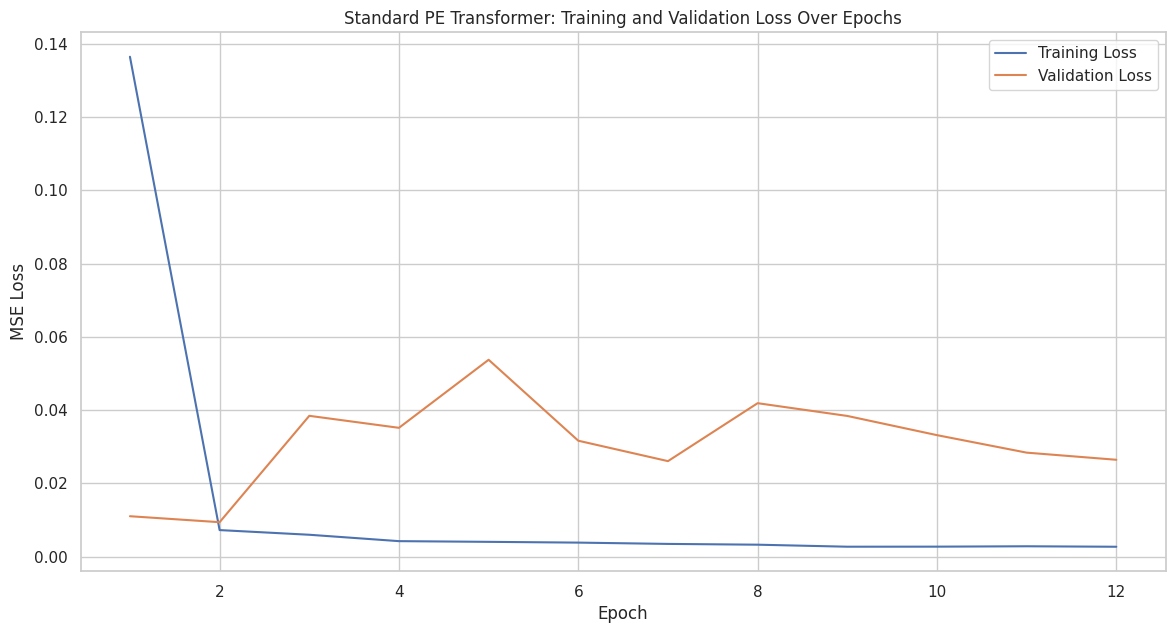

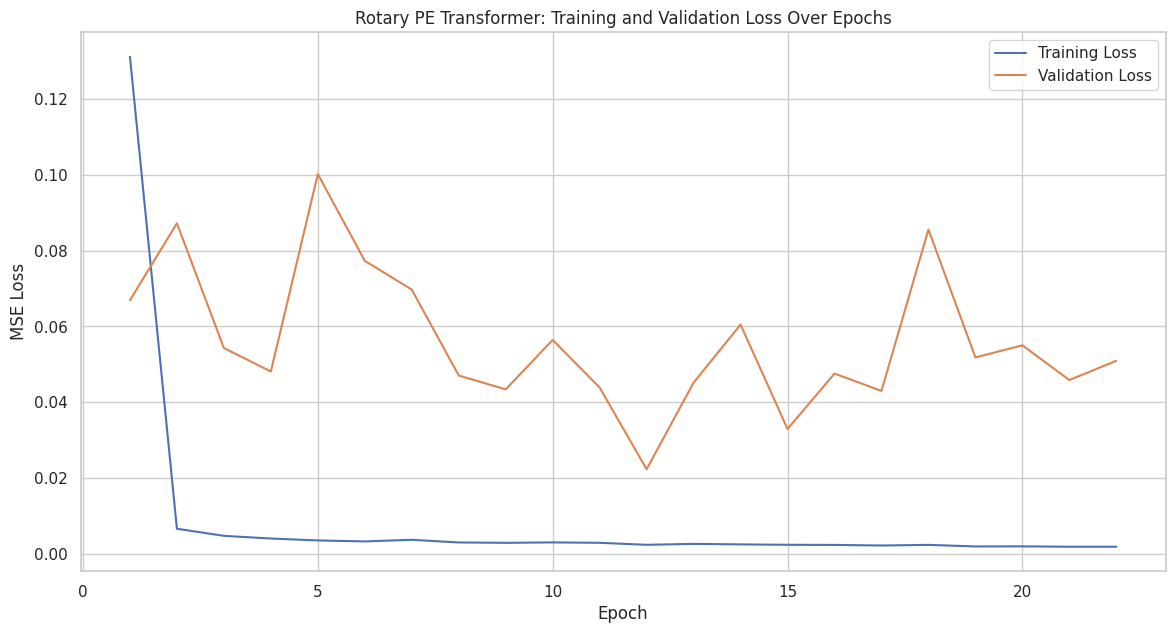

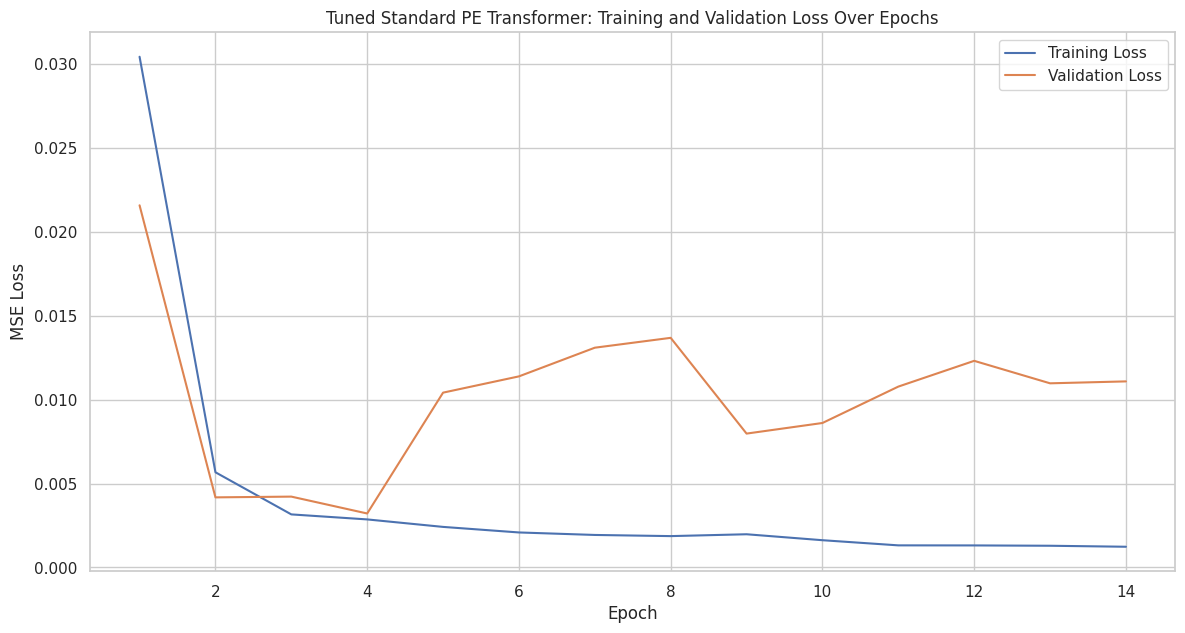

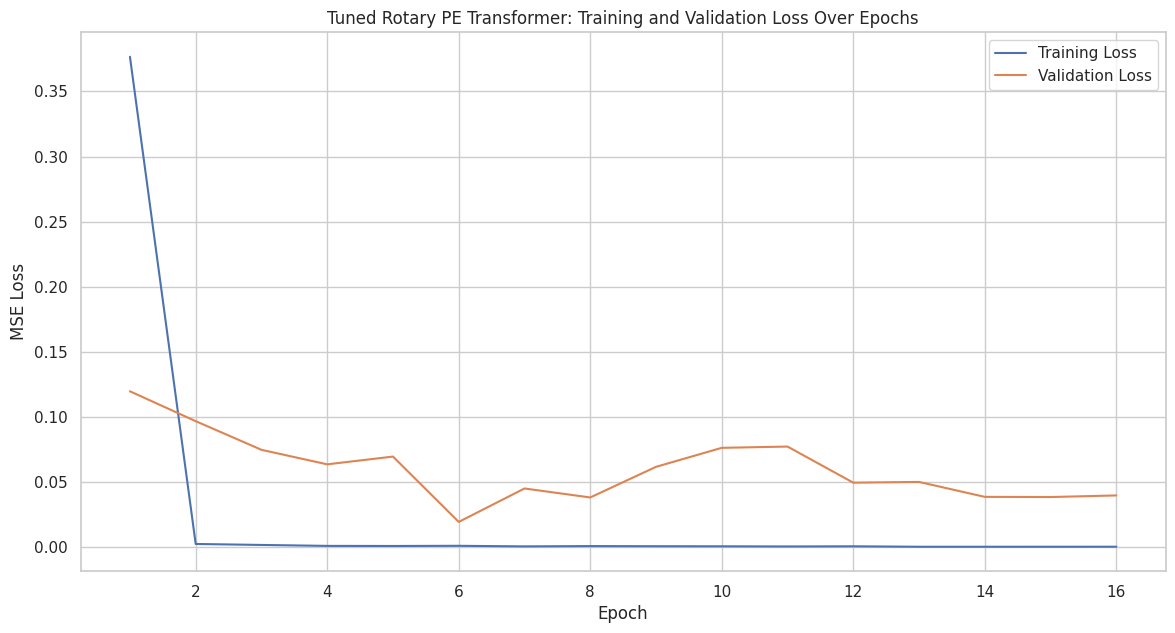

In [52]:
# Plot loss curves
plot_loss_curves(standard_train_losses, standard_val_losses, title='Standard PE Transformer: Training and Validation Loss Over Epochs')
plot_loss_curves(rotary_train_losses, rotary_val_losses, title='Rotary PE Transformer: Training and Validation Loss Over Epochs')
plot_loss_curves(tuned_standard_train_losses, tuned_standard_val_losses, title='Tuned Standard PE Transformer: Training and Validation Loss Over Epochs')
plot_loss_curves(tuned_rotary_train_losses, tuned_rotary_val_losses, title='Tuned Rotary PE Transformer: Training and Validation Loss Over Epochs')

# Compare Performances

In [53]:
def get_predictions(model, data_loader, device):
    """
    Get predictions and actual values from the data_loader.

    Args:
        model (nn.Module): Trained transformer model.
        data_loader (DataLoader): DataLoader for data.
        device (torch.device): Device to perform computations.

    Returns:
        Tuple: Predictions and actual target values.
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_X)
            predictions.append(output.cpu().numpy())
            actuals.append(batch_y.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return predictions, actuals

In [54]:
# Predictions on the test set
pred_standard_untuned, actual_standard_untuned = get_predictions(standard_model, test_loader, device)
pred_rotary_untuned, actual_rotary_untuned = get_predictions(rotary_model, test_loader, device)
pred_standard_tuned, actual_standard_tuned = get_predictions(tuned_standard_model, test_loader, device)
pred_rotary_tuned, actual_rotary_tuned = get_predictions(tuned_rotary_model, test_loader, device)

In [55]:
def inverse_transform(predictions, actuals, scaler_target):
    """
    Inverse transform the predictions and actuals to the original scale.

    Args:
        predictions (np.ndarray): Predicted values of shape (num_samples, 1).
        actuals (np.ndarray): Actual target values of shape (num_samples, 1).
        scaler_target (MinMaxScaler): Scaler used for the target.

    Returns:
        Tuple: Inverse transformed predictions and actuals.
    """
    # Ensure that predictions and actuals are 2D arrays
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    if actuals.ndim == 1:
        actuals = actuals.reshape(-1, 1)

    predicted_prices = scaler_target.inverse_transform(predictions)
    actual_prices = scaler_target.inverse_transform(actuals)
    return predicted_prices.flatten(), actual_prices.flatten()

In [56]:
# Inverse transform predictions and actuals
pred_standard_untuned_prices, actual_standard_untuned_prices = inverse_transform(
    pred_standard_untuned, actual_standard_untuned, scaler_target
)
pred_rotary_untuned_prices, actual_rotary_untuned_prices = inverse_transform(
    pred_rotary_untuned, actual_rotary_untuned, scaler_target
)
pred_standard_tuned_prices, actual_standard_tuned_prices = inverse_transform(
    pred_standard_tuned, actual_standard_tuned, scaler_target
)
pred_rotary_tuned_prices, actual_rotary_tuned_prices = inverse_transform(
    pred_rotary_tuned, actual_rotary_tuned, scaler_target
)

In [57]:
def calculate_metrics(actual, predicted):
    """
    Calculate RMSE and MAE between actual and predicted values.

    Args:
        actual (np.ndarray): Actual target values.
        predicted (np.ndarray): Predicted values.

    Returns:
        Tuple: RMSE and MAE.
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

In [58]:
# Calculate metrics
metrics = {}

# Untuned Standard Transformer
rmse, mae = calculate_metrics(actual_standard_untuned_prices, pred_standard_untuned_prices)
metrics['Standard_Untuned'] = {'RMSE': rmse, 'MAE': mae}

# Untuned Rotary Transformer
rmse, mae = calculate_metrics(actual_rotary_untuned_prices, pred_rotary_untuned_prices)
metrics['Rotary_Untuned'] = {'RMSE': rmse, 'MAE': mae}

In [59]:
# Tuned Standard Transformer
rmse, mae = calculate_metrics(actual_standard_tuned_prices, pred_standard_tuned_prices)
metrics['Standard_Tuned'] = {'RMSE': rmse, 'MAE': mae}

# Tuned Rotary Transformer
rmse, mae = calculate_metrics(actual_rotary_tuned_prices, pred_rotary_tuned_prices)
metrics['Rotary_Tuned'] = {'RMSE': rmse, 'MAE': mae}

In [60]:
# Display metrics
print("Evaluation Metrics:")
for model, metric_values in metrics.items():
    print(f"{model} - RMSE: {metric_values['RMSE']:.2f}, MAE: {metric_values['MAE']:.2f}")

Evaluation Metrics:
Standard_Untuned - RMSE: 820.87, MAE: 703.52
Rotary_Untuned - RMSE: 1328.89, MAE: 1253.52
Standard_Tuned - RMSE: 312.75, MAE: 257.82
Rotary_Tuned - RMSE: 1245.19, MAE: 1164.74


In [61]:
def plot_comparison_untuned(models, rmse_values, mae_values):
    """
    Plot bar charts comparing RMSE and MAE between two untuned models.

    Args:
        models (list): List of model names.
        rmse_values (list): List of RMSE values.
        mae_values (list): List of MAE values.
    """
    x = np.arange(len(models))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(8,6))
    rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
    rects2 = ax.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

    # Add labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Untuned Models: RMSE and MAE Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    # Adjust the y-axis limit to avoid overlapping text
    max_height = max(max(rmse_values), max(mae_values))
    ax.set_ylim(0, max_height * 1.25)  # Extend by 25%

    # Attach text labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

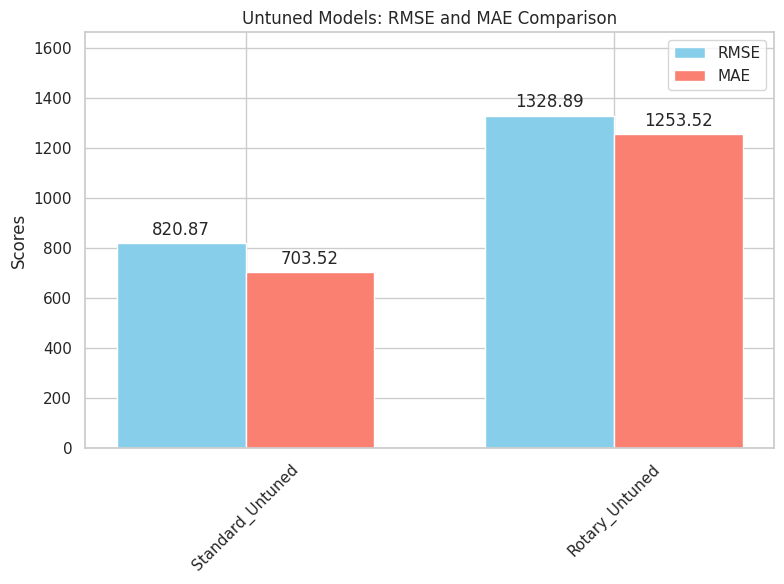

In [62]:
# Extract metrics for untuned models
untuned_models = ['Standard_Untuned', 'Rotary_Untuned']
untuned_rmse = [metrics['Standard_Untuned']['RMSE'], metrics['Rotary_Untuned']['RMSE']]
untuned_mae = [metrics['Standard_Untuned']['MAE'], metrics['Rotary_Untuned']['MAE']]

plot_comparison_untuned(untuned_models, untuned_rmse, untuned_mae)

In [63]:
def plot_comparison_tuned(models, rmse_values, mae_values):
    """
    Plot bar charts comparing RMSE and MAE between two tuned models.

    Args:
        models (list): List of model names.
        rmse_values (list): List of RMSE values.
        mae_values (list): List of MAE values.
    """
    x = np.arange(len(models))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(8,6))
    rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
    rects2 = ax.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

    # Add labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Tuned Models: RMSE and MAE Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    # Adjust the y-axis limit to avoid overlapping text
    max_height = max(max(rmse_values), max(mae_values))
    ax.set_ylim(0, max_height * 1.2)  # Extend by 20%

    # Attach text labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

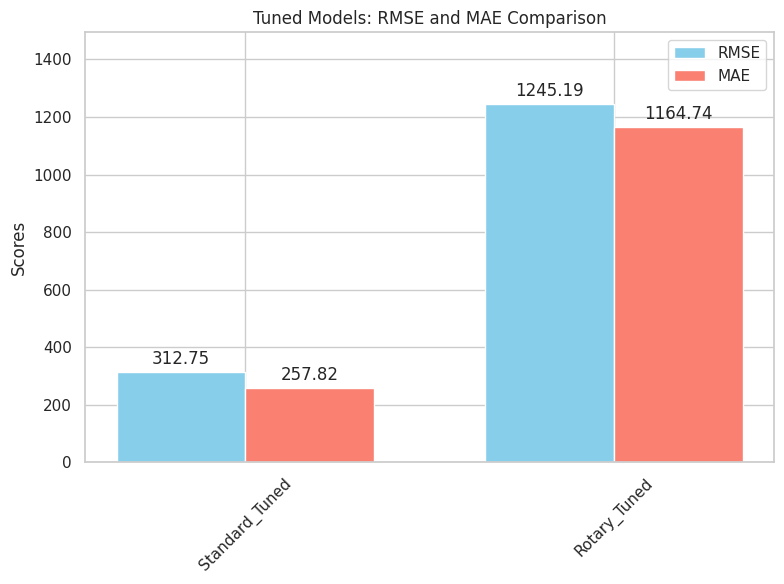

In [64]:
# Extract metrics for tuned models
tuned_models = ['Standard_Tuned', 'Rotary_Tuned']
tuned_rmse = [metrics['Standard_Tuned']['RMSE'], metrics['Rotary_Tuned']['RMSE']]
tuned_mae = [metrics['Standard_Tuned']['MAE'], metrics['Rotary_Tuned']['MAE']]

plot_comparison_tuned(tuned_models, tuned_rmse, tuned_mae)

In [65]:
def plot_comparison_all(models, rmse_values, mae_values):
    """
    Plot bar charts comparing RMSE and MAE across all four models.

    Args:
        models (list): List of model names.
        rmse_values (list): List of RMSE values.
        mae_values (list): List of MAE values.
    """
    x = np.arange(len(models))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10,6))
    rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
    rects2 = ax.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

    # Add labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('All Models: RMSE and MAE Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    # Adjust the y-axis limit to avoid overlapping text
    max_height = max(max(rmse_values), max(mae_values))
    ax.set_ylim(0, max_height * 1.2)  # Extend by 20%

    # Attach text labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

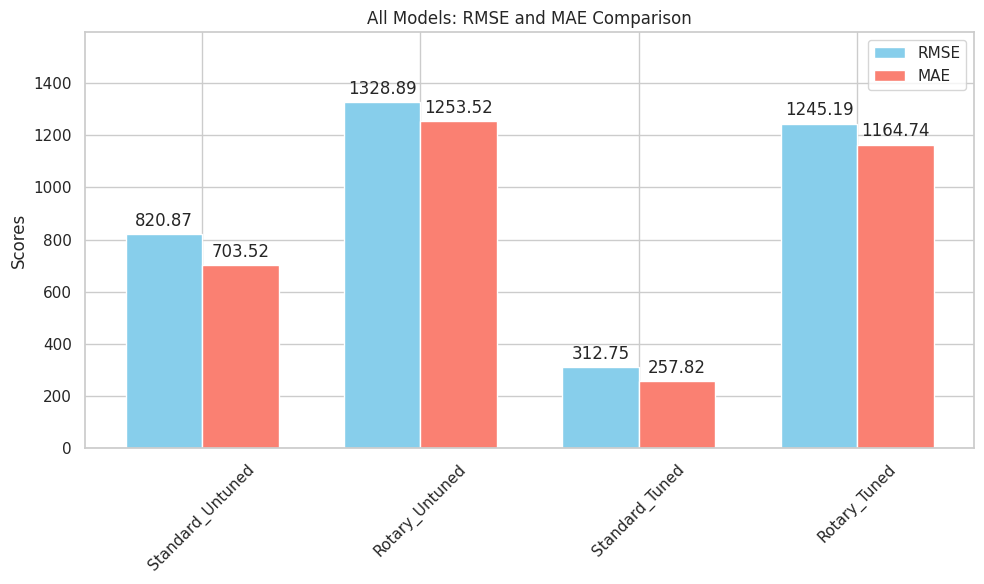

In [66]:
# Extract metrics for all models
all_models = ['Standard_Untuned', 'Rotary_Untuned', 'Standard_Tuned', 'Rotary_Tuned']
all_rmse = [metrics['Standard_Untuned']['RMSE'], metrics['Rotary_Untuned']['RMSE'],
           metrics['Standard_Tuned']['RMSE'], metrics['Rotary_Tuned']['RMSE']]
all_mae = [metrics['Standard_Untuned']['MAE'], metrics['Rotary_Untuned']['MAE'],
           metrics['Standard_Tuned']['MAE'], metrics['Rotary_Tuned']['MAE']]

plot_comparison_all(all_models, all_rmse, all_mae)

In [67]:
def plot_actual_vs_predicted(dates, actual, predicted, title='Actual vs. Predicted Prices'):
    """
    Plot actual vs. predicted prices.

    Args:
        dates (pd.DatetimeIndex): Dates corresponding to the validation set.
        actual (np.ndarray): Actual target values.
        predicted (np.ndarray): Predicted values.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(dates, actual, label='Actual Prices', color='blue')
    plt.plot(dates, predicted, label='Predicted Prices', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

# Get the corresponding dates for validation set
validation_dates = data.index[-len(actual_standard_untuned_prices):]

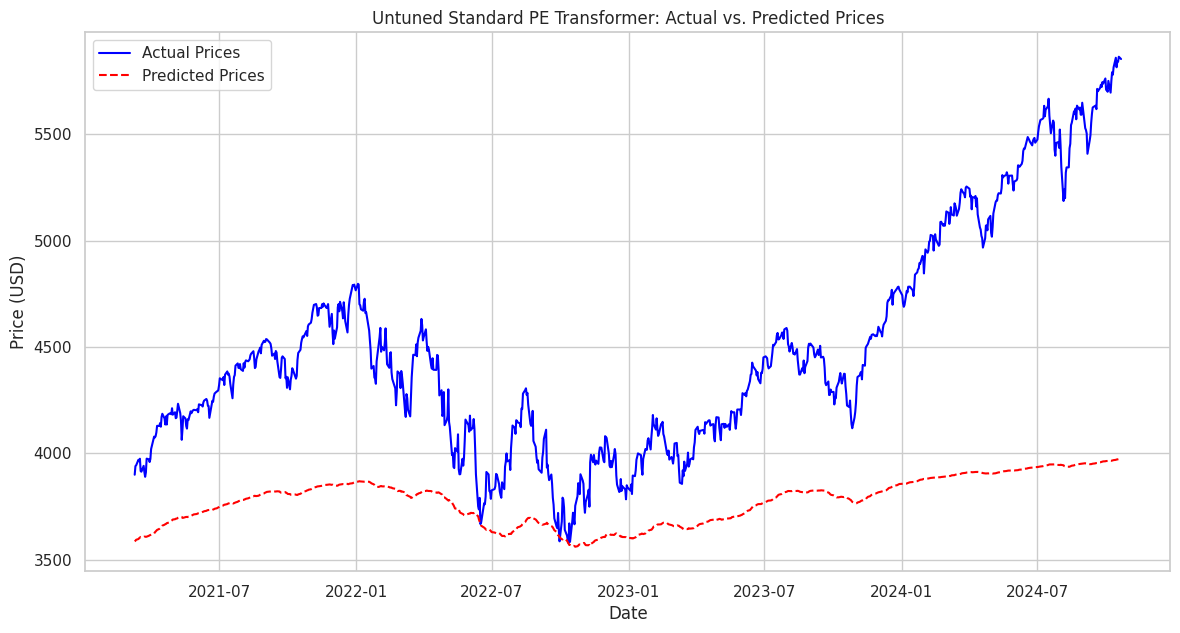

In [68]:
# Plot for Untuned Standard Transformer
plot_actual_vs_predicted(
    validation_dates,
    actual_standard_untuned_prices,
    pred_standard_untuned_prices,
    title='Untuned Standard PE Transformer: Actual vs. Predicted Prices'
)

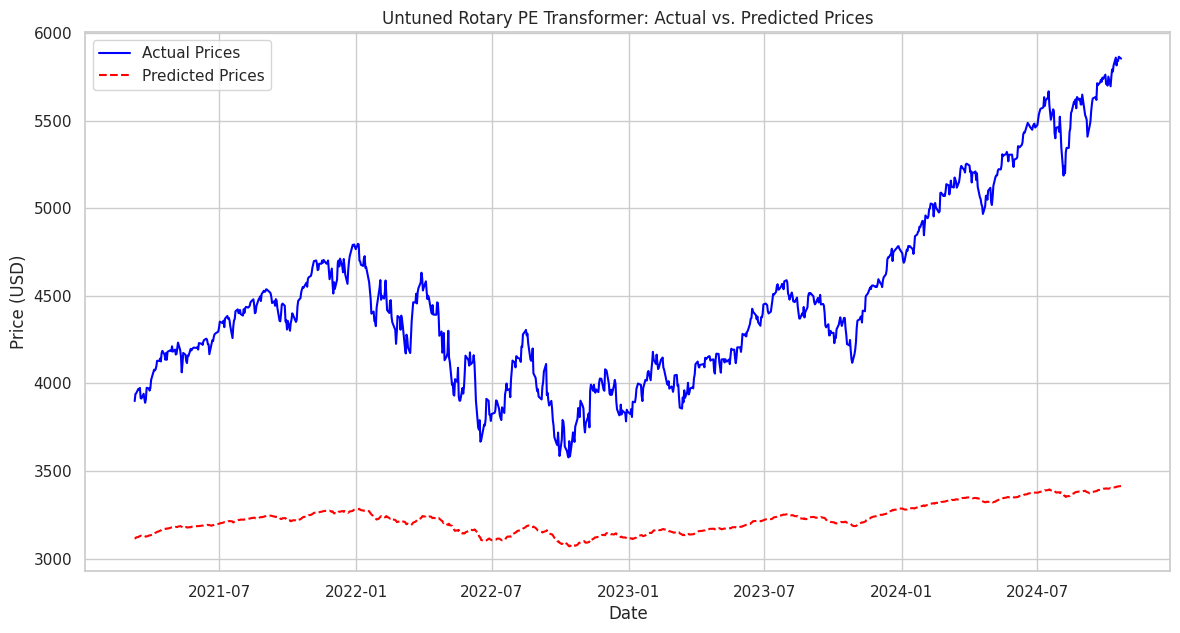

In [69]:
# Plot for Untuned Rotary Transformer
plot_actual_vs_predicted(
    validation_dates,
    actual_rotary_untuned_prices,
    pred_rotary_untuned_prices,
    title='Untuned Rotary PE Transformer: Actual vs. Predicted Prices'
)

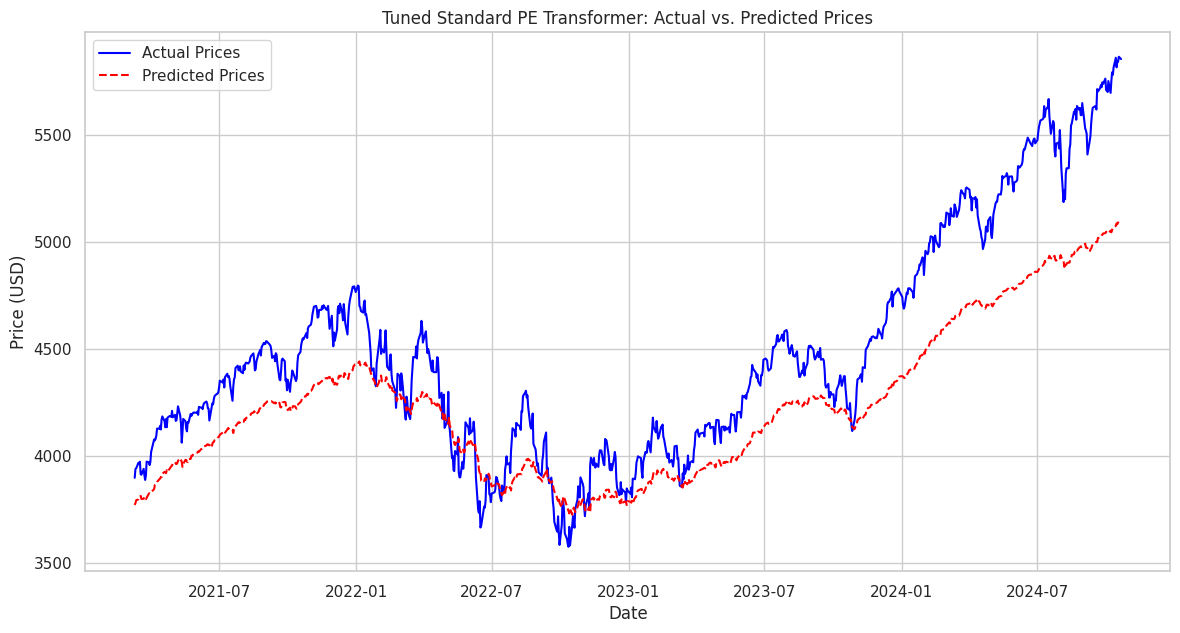

In [70]:
# Plot for Tuned Standard Transformer
plot_actual_vs_predicted(
    validation_dates,
    actual_standard_tuned_prices,
    pred_standard_tuned_prices,
    title='Tuned Standard PE Transformer: Actual vs. Predicted Prices'
)

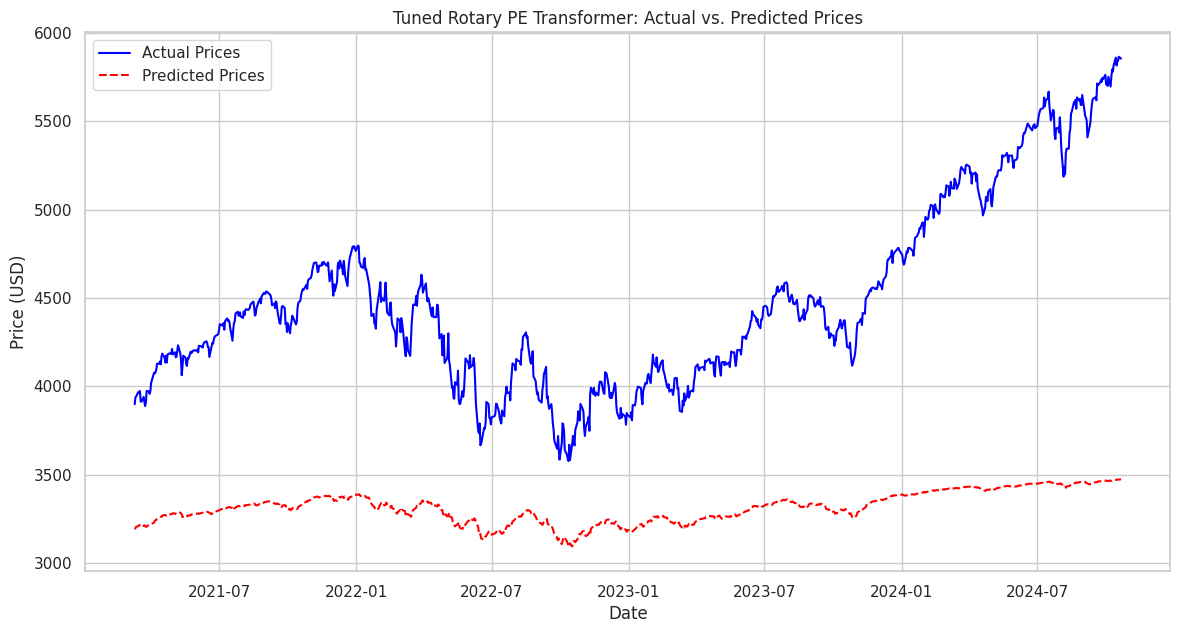

In [71]:
# Plot for Tuned Rotary Transformer
plot_actual_vs_predicted(
    validation_dates,
    actual_rotary_tuned_prices,
    pred_rotary_tuned_prices,
    title='Tuned Rotary PE Transformer: Actual vs. Predicted Prices'
)

In [72]:
def plot_actual_vs_predicted_untuned(dates, actual1, predicted1, actual2, predicted2, title='Actual vs. Predicted Prices for Untuned Models'):
    """
    Plot actual vs. predicted prices for two untuned models on the same plot.

    Args:
        dates (pd.DatetimeIndex): Dates corresponding to the validation set.
        actual1 (np.ndarray): Actual target values for Model 1.
        predicted1 (np.ndarray): Predicted values for Model 1.
        actual2 (np.ndarray): Actual target values for Model 2.
        predicted2 (np.ndarray): Predicted values for Model 2.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(dates, actual1, label='Actual Prices', color='black')
    plt.plot(dates, predicted1, label='Standard_Untuned Predictions', color='blue', linestyle='--')
    plt.plot(dates, predicted2, label='Rotary_Untuned Predictions', color='green', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

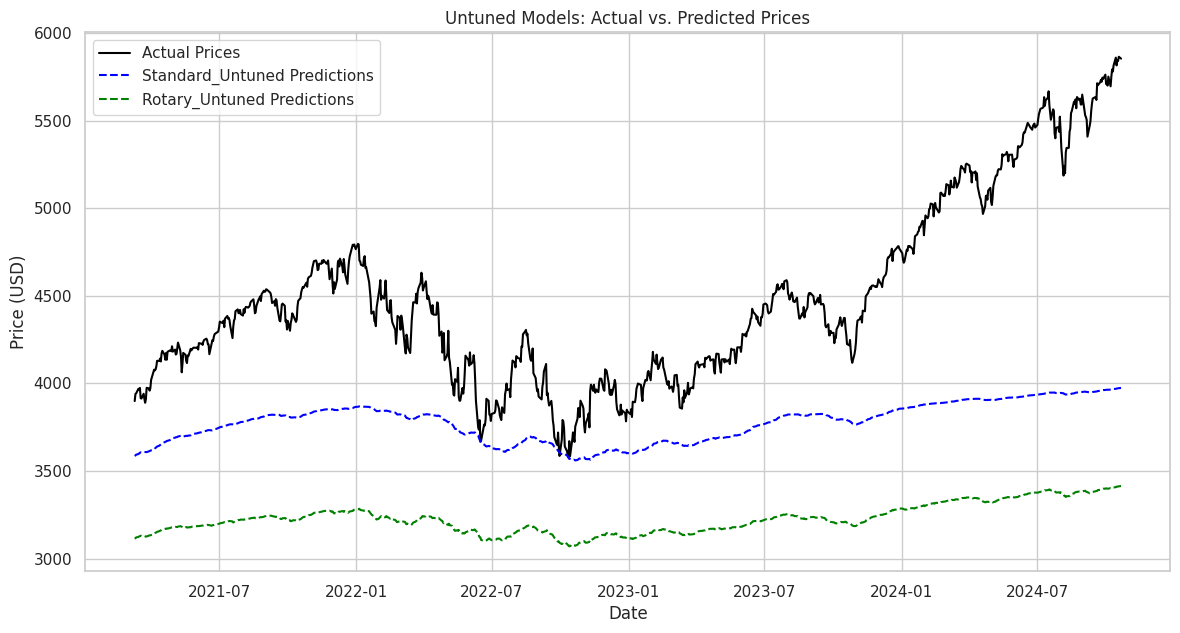

In [73]:
# Plot actual vs. predicted values for untuned models
plot_actual_vs_predicted_untuned(
    validation_dates,
    actual_standard_untuned_prices,
    pred_standard_untuned_prices,
    actual_rotary_untuned_prices,
    pred_rotary_untuned_prices,
    title='Untuned Models: Actual vs. Predicted Prices'
)

In [74]:
def plot_actual_vs_predicted_tuned(dates, actual1, predicted1, actual2, predicted2, title='Actual vs. Predicted Prices for Tuned Models'):
    """
    Plot actual vs. predicted prices for two tuned models on the same plot.

    Args:
        dates (pd.DatetimeIndex): Dates corresponding to the validation set.
        actual1 (np.ndarray): Actual target values for Model 1.
        predicted1 (np.ndarray): Predicted values for Model 1.
        actual2 (np.ndarray): Actual target values for Model 2.
        predicted2 (np.ndarray): Predicted values for Model 2.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(dates, actual1, label='Actual Prices', color='black')
    plt.plot(dates, predicted1, label='Standard_Tuned Predictions', color='blue', linestyle='--')
    plt.plot(dates, predicted2, label='Rotary_Tuned Predictions', color='green', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

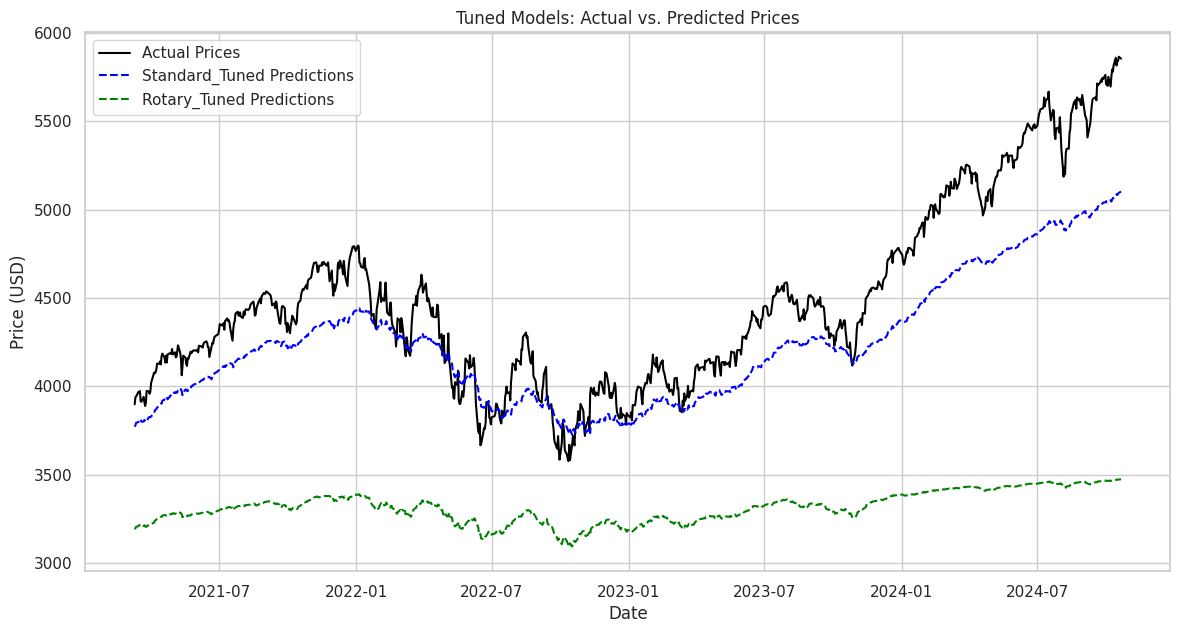

In [75]:
# Plot actual vs. predicted values for tuned models
plot_actual_vs_predicted_tuned(
    validation_dates,
    actual_standard_tuned_prices,
    pred_standard_tuned_prices,
    actual_rotary_tuned_prices,
    pred_rotary_tuned_prices,
    title='Tuned Models: Actual vs. Predicted Prices'
)

In [76]:
def plot_actual_vs_predicted_all(dates, actual, preds, titles, colors, linestyles, title='Actual vs. Predicted Prices for All Models'):
    """
    Plot actual vs. predicted prices for all four models on the same plot.

    Args:
        dates (pd.DatetimeIndex): Dates corresponding to the validation set.
        actual (np.ndarray): Actual target values.
        preds (dict): Dictionary containing model names as keys and predicted values as values.
        titles (list): List of model names for labeling.
        colors (list): List of colors for each model's predictions.
        linestyles (list): List of line styles for each model's predictions.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(dates, actual, label='Actual Prices', color='black')

    for model_name, color, linestyle in zip(titles, colors, linestyles):
        plt.plot(dates, preds[model_name], label=f'{model_name} Predictions', color=color, linestyle=linestyle)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

In [77]:
# Prepare predictions dictionary
preds_all = {
    'Standard_Untuned': pred_standard_untuned_prices,
    'Rotary_Untuned': pred_rotary_untuned_prices,
    'Standard_Tuned': pred_standard_tuned_prices,
    'Rotary_Tuned': pred_rotary_tuned_prices
}

# Define colors and linestyles for clarity
model_titles = ['Standard_Untuned', 'Rotary_Untuned', 'Standard_Tuned', 'Rotary_Tuned']
model_colors = ['blue', 'green', 'cyan', 'magenta']
model_linestyles = ['--', '--', '-.', '-.']

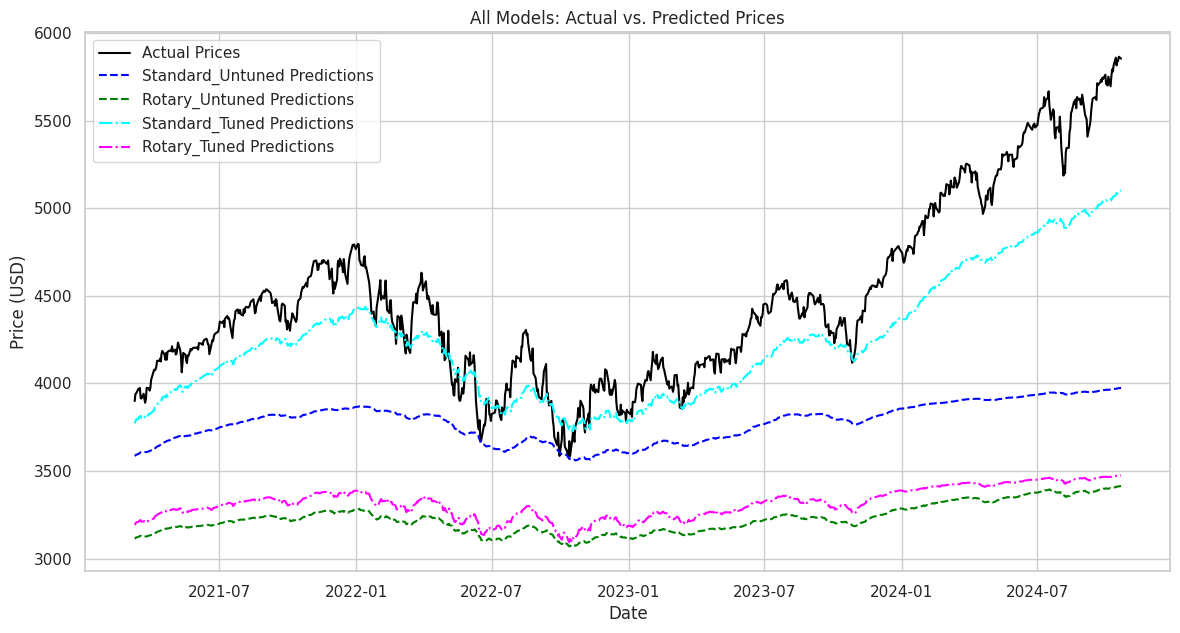

In [78]:
# Plot actual vs. predicted values for all models together
plot_actual_vs_predicted_all(
    dates=validation_dates,
    actual=actual_standard_untuned_prices,
    preds=preds_all,
    titles=model_titles,
    colors=model_colors,
    linestyles=model_linestyles,
    title='All Models: Actual vs. Predicted Prices'
)